In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dense, Reshape, Flatten, Lambda
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image_dataset_from_directory
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from numpy import reshape
import os
import PIL
from PIL import Image
from sklearn import preprocessing
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
from numpy.random import rand
import pathlib
from google.colab import drive
from keras.utils.vis_utils import plot_model
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

In [ ]:
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
data_dir_test = "/content/drive/MyDrive/COURS/Semestre_6/TER/dataClean/test"
data_dir_test = pathlib.Path(data_dir_test)
data_dir_train = "/content/drive/MyDrive/COURS/Semestre_6/TER/dataClean/train"
data_dir_train = pathlib.Path(data_dir_train)
data_path = "/content/drive/MyDrive/COURS/Semestre_6/TER/data"
data_path = pathlib.Path(data_path)
print(data_path)

/content/drive/MyDrive/COURS/Semestre_6/TER/data


In [ ]:
image_count_test = len(list(data_dir_test.glob('*/*.png')))
print(image_count_test)
print(data_dir_test)

image_count_train = len(list(data_dir_train.glob('*/*.png')))
print(image_count_train)
print(data_dir_train)

552
/content/drive/MyDrive/COURS/Semestre_6/TER/dataClean/test
2039
/content/drive/MyDrive/COURS/Semestre_6/TER/dataClean/train


In [ ]:
img_rows = 24
img_cols = 25
batch_size = 200

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(24,24,1)):
	model = Sequential()
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Dropout(0.4))
	model.add(Flatten())
	model.add(Dense(1, activation='sigmoid'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 6x6 image
	n_nodes = 128 * 6 * 6
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((6, 6, 128)))
	# upsample to 12x12
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 24x24
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (6,6), activation='sigmoid', padding='same'))
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
data_path = "/content/drive/MyDrive/COURS/Semestre_6/TER/data"
data_path = pathlib.Path(data_path)
print(data_path)

/content/drive/MyDrive/COURS/Semestre_6/TER/data


In [ ]:
# load and prepare mnist training images
def load_real_samples():

	train_ds = tf.keras.preprocessing.image_dataset_from_directory(
      data_path,
      image_size=(img_rows, img_cols),
      color_mode = "grayscale",
      batch_size=batch_size)
 
	for image_batch, labels_batch in train_ds:
		image_batch=image_batch/255
		break

	#for elt in train_ds : 
	#	elt=tf.image.resize(elt,(0,1))
	#	print(elt)
	array=np.array(image_batch)
	array=np.delete(array, (0),axis=2)
	#return(image_batch.shape
	return array

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
# generate n fake samples with class labels
def generate_fake_samples2(n_samples):
	# generate uniform random numbers in [0,1]
	X = rand(24 * 24 * n_samples)
	# reshape into a batch of grayscale images
	X = X.reshape((n_samples, 24, 24, 1))
	# generate 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.show()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples2(n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%d.h5' % (epoch + 1)
	#filename = 'generator_model_10.h5' #% (epoch + 1)
	g_model.save(filename)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=20):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=100, n_batch=batch_size):
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_iter):
		# get randomly selected 'real' samples
		X_real, y_real = generate_real_samples(dataset, half_batch)
		# update discriminator on real samples
		_, real_acc = model.train_on_batch(X_real, y_real)
		# generate 'fake' examples
		X_fake, y_fake = generate_fake_samples2(half_batch)
		# update discriminator on fake samples
		_, fake_acc = model.train_on_batch(X_fake, y_fake)
		# summarize performance
		print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=500, n_batch=25):
	# manually enumerate epochs
	for i in range(n_epochs):
		# prepare points in latent space as input for the generator
		x_gan = generate_latent_points(latent_dim, n_batch)
		# create inverted labels for the fake samples
		y_gan = ones((n_batch, 1))
		# update the generator via the discriminator's error
		gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# define the discriminator model
model = define_discriminator()
# load image data
dataset = load_real_samples()
# fit the model
train_discriminator(model, dataset)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 24, 24, 1)         994561    
                                                                 
 sequential_4 (Sequential)   (None, 1)                 39873     
                                                                 
Total params: 1,034,434
Trainable params: 994,561
Non-trainable params: 39,873
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


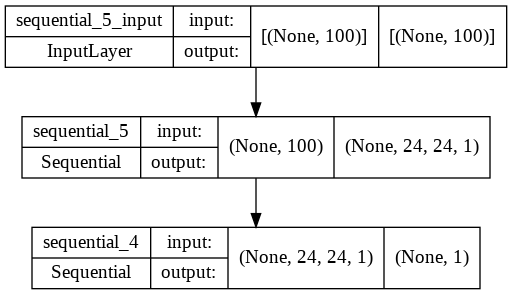

In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# summarize gan model
gan_model.summary()
# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
train_gan(gan_model, latent_dim)

>1, 1/10, d=0.871, g=0.506
>1, 2/10, d=0.850, g=0.517
>1, 3/10, d=0.808, g=0.531
>1, 4/10, d=0.809, g=0.542
>1, 5/10, d=0.790, g=0.540
>1, 6/10, d=0.771, g=0.572
>1, 7/10, d=0.764, g=0.593
>1, 8/10, d=0.766, g=0.615
>1, 9/10, d=0.764, g=0.622
>1, 10/10, d=0.740, g=0.618
>2, 1/10, d=0.737, g=0.649
>2, 2/10, d=0.715, g=0.651
>2, 3/10, d=0.704, g=0.690
>2, 4/10, d=0.703, g=0.707
>2, 5/10, d=0.698, g=0.696
>2, 6/10, d=0.704, g=0.717
>2, 7/10, d=0.676, g=0.754
>2, 8/10, d=0.693, g=0.747
>2, 9/10, d=0.661, g=0.757
>2, 10/10, d=0.666, g=0.774
>3, 1/10, d=0.658, g=0.812
>3, 2/10, d=0.641, g=0.831
>3, 3/10, d=0.647, g=0.814
>3, 4/10, d=0.630, g=0.833
>3, 5/10, d=0.621, g=0.863
>3, 6/10, d=0.621, g=0.873
>3, 7/10, d=0.600, g=0.872
>3, 8/10, d=0.634, g=0.824
>3, 9/10, d=0.648, g=0.848
>3, 10/10, d=0.613, g=0.816
>4, 1/10, d=0.608, g=0.850
>4, 2/10, d=0.613, g=0.865
>4, 3/10, d=0.600, g=0.835
>4, 4/10, d=0.612, g=0.827
>4, 5/10, d=0.613, g=0.809
>4, 6/10, d=0.604, g=0.794
>4, 7/10, d=0.604, g=0.78

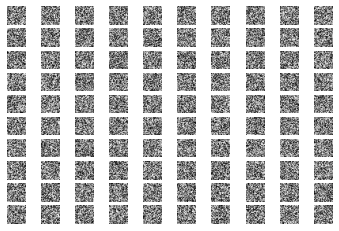

>11, 1/10, d=0.088, g=1.861
>11, 2/10, d=0.090, g=1.956
>11, 3/10, d=0.093, g=1.992
>11, 4/10, d=0.095, g=2.103
>11, 5/10, d=0.085, g=2.119
>11, 6/10, d=0.069, g=2.140
>11, 7/10, d=0.074, g=2.185
>11, 8/10, d=0.069, g=2.256
>11, 9/10, d=0.072, g=2.354
>11, 10/10, d=0.061, g=2.374
>12, 1/10, d=0.053, g=2.381
>12, 2/10, d=0.059, g=2.475
>12, 3/10, d=0.056, g=2.496
>12, 4/10, d=0.048, g=2.554
>12, 5/10, d=0.048, g=2.608
>12, 6/10, d=0.040, g=2.654
>12, 7/10, d=0.046, g=2.647
>12, 8/10, d=0.046, g=2.681
>12, 9/10, d=0.048, g=2.785
>12, 10/10, d=0.040, g=2.783
>13, 1/10, d=0.037, g=2.829
>13, 2/10, d=0.037, g=2.906
>13, 3/10, d=0.036, g=2.954
>13, 4/10, d=0.030, g=2.976
>13, 5/10, d=0.033, g=3.049
>13, 6/10, d=0.026, g=3.011
>13, 7/10, d=0.033, g=3.117
>13, 8/10, d=0.027, g=3.104
>13, 9/10, d=0.027, g=3.119
>13, 10/10, d=0.023, g=3.192
>14, 1/10, d=0.026, g=3.305
>14, 2/10, d=0.024, g=3.284
>14, 3/10, d=0.025, g=3.296
>14, 4/10, d=0.022, g=3.375
>14, 5/10, d=0.020, g=3.360
>14, 6/10, d=0.02

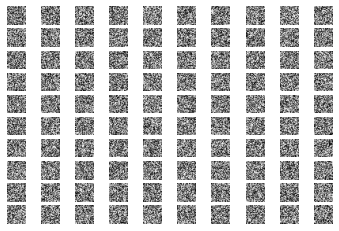

>21, 1/10, d=0.004, g=4.997
>21, 2/10, d=0.005, g=5.065
>21, 3/10, d=0.004, g=5.021
>21, 4/10, d=0.004, g=5.072
>21, 5/10, d=0.004, g=5.034
>21, 6/10, d=0.004, g=5.099
>21, 7/10, d=0.007, g=5.044
>21, 8/10, d=0.005, g=5.069
>21, 9/10, d=0.006, g=5.130
>21, 10/10, d=0.004, g=5.038
>22, 1/10, d=0.005, g=5.075
>22, 2/10, d=0.003, g=5.125
>22, 3/10, d=0.004, g=5.173
>22, 4/10, d=0.005, g=5.190
>22, 5/10, d=0.006, g=5.181
>22, 6/10, d=0.005, g=5.188
>22, 7/10, d=0.003, g=5.226
>22, 8/10, d=0.004, g=5.309
>22, 9/10, d=0.005, g=5.277
>22, 10/10, d=0.004, g=5.271
>23, 1/10, d=0.003, g=5.294
>23, 2/10, d=0.005, g=5.325
>23, 3/10, d=0.005, g=5.270
>23, 4/10, d=0.003, g=5.242
>23, 5/10, d=0.004, g=5.427
>23, 6/10, d=0.006, g=5.422
>23, 7/10, d=0.003, g=5.300
>23, 8/10, d=0.003, g=5.217
>23, 9/10, d=0.003, g=5.472
>23, 10/10, d=0.005, g=5.404
>24, 1/10, d=0.003, g=5.452
>24, 2/10, d=0.004, g=5.376
>24, 3/10, d=0.004, g=5.406
>24, 4/10, d=0.003, g=5.359
>24, 5/10, d=0.003, g=5.450
>24, 6/10, d=0.00

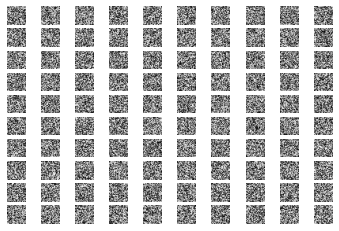

>31, 1/10, d=0.994, g=0.982
>31, 2/10, d=0.989, g=0.815
>31, 3/10, d=0.858, g=1.003
>31, 4/10, d=0.891, g=0.979
>31, 5/10, d=0.892, g=0.884
>31, 6/10, d=0.890, g=0.884
>31, 7/10, d=0.909, g=1.034
>31, 8/10, d=0.924, g=0.995
>31, 9/10, d=0.871, g=1.191
>31, 10/10, d=0.844, g=1.132
>32, 1/10, d=0.795, g=0.922
>32, 2/10, d=0.847, g=1.142
>32, 3/10, d=0.874, g=0.924
>32, 4/10, d=0.829, g=1.013
>32, 5/10, d=0.821, g=1.124
>32, 6/10, d=0.818, g=1.026
>32, 7/10, d=0.831, g=0.987
>32, 8/10, d=0.737, g=1.065
>32, 9/10, d=0.814, g=1.203
>32, 10/10, d=0.699, g=1.244
>33, 1/10, d=0.769, g=1.123
>33, 2/10, d=0.764, g=1.114
>33, 3/10, d=0.797, g=1.195
>33, 4/10, d=0.801, g=1.265
>33, 5/10, d=0.726, g=1.116
>33, 6/10, d=0.721, g=1.186
>33, 7/10, d=0.713, g=1.096
>33, 8/10, d=0.719, g=1.139
>33, 9/10, d=0.688, g=1.075
>33, 10/10, d=0.756, g=1.218
>34, 1/10, d=0.726, g=1.314
>34, 2/10, d=0.712, g=1.235
>34, 3/10, d=0.686, g=0.997
>34, 4/10, d=0.694, g=1.182
>34, 5/10, d=0.691, g=1.058
>34, 6/10, d=0.68

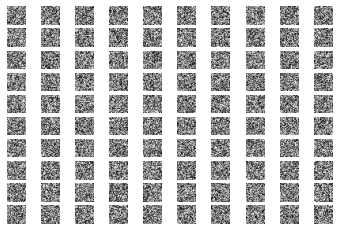

>41, 1/10, d=0.303, g=1.731
>41, 2/10, d=0.327, g=1.792
>41, 3/10, d=0.280, g=1.747
>41, 4/10, d=0.306, g=2.047
>41, 5/10, d=0.335, g=1.859
>41, 6/10, d=0.276, g=1.874
>41, 7/10, d=0.305, g=1.958
>41, 8/10, d=0.231, g=2.081
>41, 9/10, d=0.230, g=2.247
>41, 10/10, d=0.262, g=1.697
>42, 1/10, d=0.293, g=1.855
>42, 2/10, d=0.321, g=1.823
>42, 3/10, d=0.219, g=2.124
>42, 4/10, d=0.206, g=2.378
>42, 5/10, d=0.265, g=1.831
>42, 6/10, d=0.283, g=1.511
>42, 7/10, d=0.265, g=1.871
>42, 8/10, d=0.292, g=2.137
>42, 9/10, d=0.232, g=2.045
>42, 10/10, d=0.155, g=2.098
>43, 1/10, d=0.206, g=2.408
>43, 2/10, d=0.191, g=2.276
>43, 3/10, d=0.184, g=2.330
>43, 4/10, d=0.153, g=2.618
>43, 5/10, d=0.171, g=2.617
>43, 6/10, d=0.199, g=2.232
>43, 7/10, d=0.210, g=1.758
>43, 8/10, d=0.200, g=2.231
>43, 9/10, d=0.177, g=2.628
>43, 10/10, d=0.182, g=2.482
>44, 1/10, d=0.220, g=2.206
>44, 2/10, d=0.212, g=2.051
>44, 3/10, d=0.142, g=2.413
>44, 4/10, d=0.151, g=2.420
>44, 5/10, d=0.149, g=2.369
>44, 6/10, d=0.16

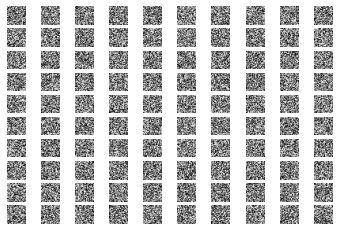

>51, 1/10, d=0.047, g=3.717
>51, 2/10, d=0.050, g=3.493
>51, 3/10, d=0.079, g=3.278
>51, 4/10, d=0.085, g=3.012
>51, 5/10, d=0.059, g=3.307
>51, 6/10, d=0.062, g=3.564
>51, 7/10, d=0.067, g=3.405
>51, 8/10, d=0.053, g=3.052
>51, 9/10, d=0.043, g=3.428
>51, 10/10, d=0.039, g=3.564
>52, 1/10, d=0.059, g=3.560
>52, 2/10, d=0.047, g=3.270
>52, 3/10, d=0.030, g=3.519
>52, 4/10, d=0.038, g=4.018
>52, 5/10, d=0.027, g=3.790
>52, 6/10, d=0.025, g=3.939
>52, 7/10, d=0.030, g=4.036
>52, 8/10, d=0.046, g=4.148
>52, 9/10, d=0.055, g=3.704
>52, 10/10, d=0.031, g=3.693
>53, 1/10, d=0.043, g=3.767
>53, 2/10, d=0.037, g=3.779
>53, 3/10, d=0.039, g=3.871
>53, 4/10, d=0.027, g=3.969
>53, 5/10, d=0.057, g=4.065
>53, 6/10, d=0.048, g=3.584
>53, 7/10, d=0.037, g=3.652
>53, 8/10, d=0.034, g=3.479
>53, 9/10, d=0.030, g=3.587
>53, 10/10, d=0.030, g=3.749
>54, 1/10, d=0.044, g=3.944
>54, 2/10, d=0.034, g=3.905
>54, 3/10, d=0.114, g=3.268
>54, 4/10, d=0.086, g=2.680
>54, 5/10, d=0.053, g=3.243
>54, 6/10, d=0.02

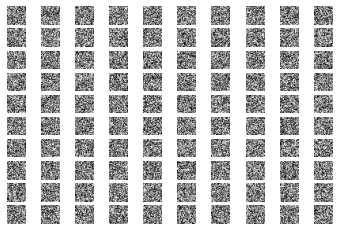

>61, 1/10, d=0.062, g=2.988
>61, 2/10, d=0.052, g=2.987
>61, 3/10, d=0.040, g=3.084
>61, 4/10, d=0.049, g=3.118
>61, 5/10, d=0.043, g=3.231
>61, 6/10, d=0.040, g=3.171
>61, 7/10, d=0.045, g=3.100
>61, 8/10, d=0.050, g=2.992
>61, 9/10, d=0.050, g=2.911
>61, 10/10, d=0.066, g=2.732
>62, 1/10, d=0.086, g=2.167
>62, 2/10, d=0.357, g=1.710
>62, 3/10, d=0.262, g=2.263
>62, 4/10, d=0.166, g=2.691
>62, 5/10, d=0.128, g=3.104
>62, 6/10, d=0.170, g=2.771
>62, 7/10, d=0.190, g=2.386
>62, 8/10, d=0.217, g=2.721
>62, 9/10, d=0.172, g=2.645
>62, 10/10, d=0.180, g=2.783
>63, 1/10, d=0.216, g=2.512
>63, 2/10, d=0.178, g=2.546
>63, 3/10, d=0.178, g=2.408
>63, 4/10, d=0.201, g=2.403
>63, 5/10, d=0.200, g=2.320
>63, 6/10, d=0.257, g=2.380
>63, 7/10, d=0.217, g=2.365
>63, 8/10, d=0.238, g=2.041
>63, 9/10, d=0.242, g=2.278
>63, 10/10, d=0.251, g=2.275
>64, 1/10, d=0.228, g=2.188
>64, 2/10, d=0.182, g=2.432
>64, 3/10, d=0.165, g=2.562
>64, 4/10, d=0.179, g=2.527
>64, 5/10, d=0.176, g=2.312
>64, 6/10, d=0.17

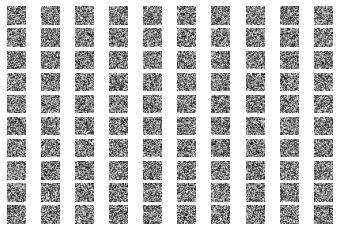

>71, 1/10, d=0.840, g=0.731
>71, 2/10, d=0.755, g=0.689
>71, 3/10, d=0.749, g=0.679
>71, 4/10, d=0.823, g=0.600
>71, 5/10, d=0.813, g=0.628
>71, 6/10, d=0.745, g=0.732
>71, 7/10, d=0.762, g=0.744
>71, 8/10, d=0.802, g=0.653
>71, 9/10, d=0.793, g=0.806
>71, 10/10, d=0.807, g=0.644
>72, 1/10, d=0.743, g=0.679
>72, 2/10, d=0.737, g=0.724
>72, 3/10, d=0.775, g=0.700
>72, 4/10, d=0.727, g=0.682
>72, 5/10, d=0.780, g=0.782
>72, 6/10, d=0.763, g=0.828
>72, 7/10, d=0.929, g=0.518
>72, 8/10, d=0.718, g=0.524
>72, 9/10, d=0.705, g=0.726
>72, 10/10, d=0.674, g=0.716
>73, 1/10, d=0.726, g=0.714
>73, 2/10, d=0.709, g=0.738
>73, 3/10, d=0.732, g=0.730
>73, 4/10, d=0.693, g=0.697
>73, 5/10, d=0.704, g=0.707
>73, 6/10, d=0.743, g=0.772
>73, 7/10, d=0.766, g=0.751
>73, 8/10, d=0.680, g=0.743
>73, 9/10, d=0.761, g=0.627
>73, 10/10, d=0.697, g=0.687
>74, 1/10, d=0.753, g=0.670
>74, 2/10, d=0.680, g=0.718
>74, 3/10, d=0.805, g=0.678
>74, 4/10, d=0.695, g=0.757
>74, 5/10, d=0.730, g=0.702
>74, 6/10, d=0.83

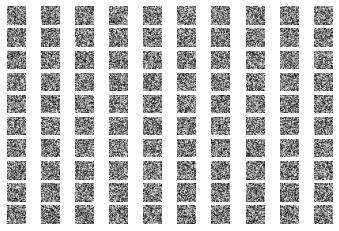

>81, 1/10, d=0.752, g=0.730
>81, 2/10, d=0.692, g=0.697
>81, 3/10, d=0.759, g=0.623
>81, 4/10, d=0.711, g=0.738
>81, 5/10, d=0.731, g=0.698
>81, 6/10, d=0.722, g=0.662
>81, 7/10, d=0.697, g=0.584
>81, 8/10, d=0.724, g=0.640
>81, 9/10, d=0.737, g=0.656
>81, 10/10, d=0.690, g=0.673
>82, 1/10, d=0.762, g=0.686
>82, 2/10, d=0.721, g=0.705
>82, 3/10, d=0.761, g=0.627
>82, 4/10, d=0.745, g=0.706
>82, 5/10, d=0.648, g=0.725
>82, 6/10, d=0.698, g=0.710
>82, 7/10, d=0.747, g=0.693
>82, 8/10, d=0.675, g=0.706
>82, 9/10, d=0.695, g=0.686
>82, 10/10, d=0.753, g=0.649
>83, 1/10, d=0.767, g=0.690
>83, 2/10, d=0.762, g=0.711
>83, 3/10, d=0.721, g=0.683
>83, 4/10, d=0.710, g=0.640
>83, 5/10, d=0.704, g=0.686
>83, 6/10, d=0.709, g=0.653
>83, 7/10, d=0.705, g=0.643
>83, 8/10, d=0.715, g=0.681
>83, 9/10, d=0.709, g=0.709
>83, 10/10, d=0.759, g=0.607
>84, 1/10, d=0.713, g=0.679
>84, 2/10, d=0.758, g=0.696
>84, 3/10, d=0.658, g=0.684
>84, 4/10, d=0.669, g=0.708
>84, 5/10, d=0.656, g=0.759
>84, 6/10, d=0.70

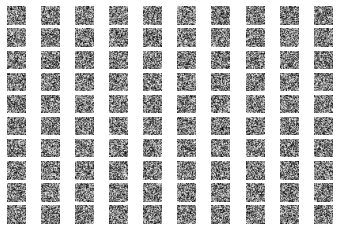

>91, 1/10, d=0.686, g=0.673
>91, 2/10, d=0.754, g=0.608
>91, 3/10, d=0.732, g=0.679
>91, 4/10, d=0.747, g=0.777
>91, 5/10, d=0.718, g=0.772
>91, 6/10, d=0.712, g=0.727
>91, 7/10, d=0.709, g=0.633
>91, 8/10, d=0.725, g=0.693
>91, 9/10, d=0.709, g=0.638
>91, 10/10, d=0.709, g=0.620
>92, 1/10, d=0.748, g=0.632
>92, 2/10, d=0.742, g=0.681
>92, 3/10, d=0.728, g=0.641
>92, 4/10, d=0.690, g=0.687
>92, 5/10, d=0.699, g=0.654
>92, 6/10, d=0.734, g=0.752
>92, 7/10, d=0.700, g=0.706
>92, 8/10, d=0.711, g=0.692
>92, 9/10, d=0.746, g=0.696
>92, 10/10, d=0.680, g=0.741
>93, 1/10, d=0.701, g=0.795
>93, 2/10, d=0.756, g=0.679
>93, 3/10, d=0.714, g=0.662
>93, 4/10, d=0.717, g=0.705
>93, 5/10, d=0.693, g=0.696
>93, 6/10, d=0.721, g=0.696
>93, 7/10, d=0.682, g=0.734
>93, 8/10, d=0.687, g=0.723
>93, 9/10, d=0.765, g=0.712
>93, 10/10, d=0.665, g=0.686
>94, 1/10, d=0.685, g=0.647
>94, 2/10, d=0.706, g=0.653
>94, 3/10, d=0.707, g=0.776
>94, 4/10, d=0.696, g=0.672
>94, 5/10, d=0.667, g=0.726
>94, 6/10, d=0.73

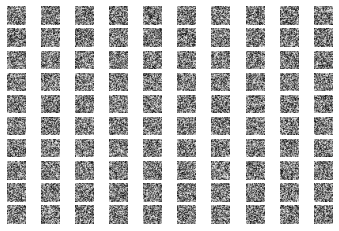

>101, 1/10, d=0.680, g=0.660
>101, 2/10, d=0.662, g=0.783
>101, 3/10, d=0.700, g=0.716
>101, 4/10, d=0.758, g=0.646
>101, 5/10, d=0.701, g=0.659
>101, 6/10, d=0.719, g=0.674
>101, 7/10, d=0.694, g=0.739
>101, 8/10, d=0.699, g=0.692
>101, 9/10, d=0.689, g=0.725
>101, 10/10, d=0.732, g=0.693
>102, 1/10, d=0.742, g=0.717
>102, 2/10, d=0.724, g=0.679
>102, 3/10, d=0.698, g=0.627
>102, 4/10, d=0.736, g=0.680
>102, 5/10, d=0.669, g=0.703
>102, 6/10, d=0.680, g=0.740
>102, 7/10, d=0.689, g=0.755
>102, 8/10, d=0.737, g=0.736
>102, 9/10, d=0.657, g=0.634
>102, 10/10, d=0.724, g=0.689
>103, 1/10, d=0.691, g=0.683
>103, 2/10, d=0.715, g=0.755
>103, 3/10, d=0.699, g=0.734
>103, 4/10, d=0.694, g=0.742
>103, 5/10, d=0.719, g=0.723
>103, 6/10, d=0.705, g=0.691
>103, 7/10, d=0.699, g=0.684
>103, 8/10, d=0.721, g=0.766
>103, 9/10, d=0.661, g=0.734
>103, 10/10, d=0.738, g=0.707
>104, 1/10, d=0.691, g=0.683
>104, 2/10, d=0.696, g=0.654
>104, 3/10, d=0.699, g=0.665
>104, 4/10, d=0.720, g=0.697
>104, 5/10,

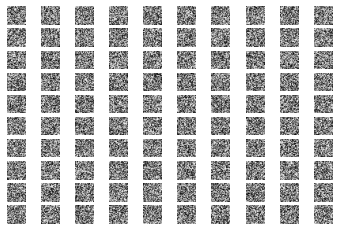

>111, 1/10, d=0.699, g=0.677
>111, 2/10, d=0.708, g=0.670
>111, 3/10, d=0.697, g=0.710
>111, 4/10, d=0.667, g=0.688
>111, 5/10, d=0.693, g=0.663
>111, 6/10, d=0.703, g=0.657
>111, 7/10, d=0.686, g=0.720
>111, 8/10, d=0.719, g=0.734
>111, 9/10, d=0.680, g=0.779
>111, 10/10, d=0.666, g=0.692
>112, 1/10, d=0.687, g=0.718
>112, 2/10, d=0.676, g=0.703
>112, 3/10, d=0.703, g=0.779
>112, 4/10, d=0.720, g=0.703
>112, 5/10, d=0.700, g=0.664
>112, 6/10, d=0.722, g=0.739
>112, 7/10, d=0.669, g=0.721
>112, 8/10, d=0.713, g=0.646
>112, 9/10, d=0.732, g=0.630
>112, 10/10, d=0.714, g=0.681
>113, 1/10, d=0.677, g=0.677
>113, 2/10, d=0.728, g=0.652
>113, 3/10, d=0.712, g=0.688
>113, 4/10, d=0.720, g=0.658
>113, 5/10, d=0.716, g=0.733
>113, 6/10, d=0.731, g=0.671
>113, 7/10, d=0.735, g=0.652
>113, 8/10, d=0.728, g=0.642
>113, 9/10, d=0.689, g=0.677
>113, 10/10, d=0.743, g=0.707
>114, 1/10, d=0.694, g=0.684
>114, 2/10, d=0.708, g=0.724
>114, 3/10, d=0.679, g=0.714
>114, 4/10, d=0.699, g=0.735
>114, 5/10,

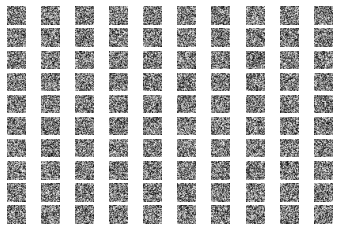

>121, 1/10, d=0.740, g=0.679
>121, 2/10, d=0.686, g=0.733
>121, 3/10, d=0.686, g=0.673
>121, 4/10, d=0.731, g=0.638
>121, 5/10, d=0.716, g=0.658
>121, 6/10, d=0.717, g=0.657
>121, 7/10, d=0.722, g=0.653
>121, 8/10, d=0.712, g=0.727
>121, 9/10, d=0.743, g=0.719
>121, 10/10, d=0.696, g=0.727
>122, 1/10, d=0.686, g=0.685
>122, 2/10, d=0.703, g=0.689
>122, 3/10, d=0.711, g=0.673
>122, 4/10, d=0.680, g=0.691
>122, 5/10, d=0.695, g=0.735
>122, 6/10, d=0.722, g=0.776
>122, 7/10, d=0.723, g=0.691
>122, 8/10, d=0.754, g=0.628
>122, 9/10, d=0.670, g=0.592
>122, 10/10, d=0.681, g=0.637
>123, 1/10, d=0.712, g=0.662
>123, 2/10, d=0.726, g=0.752
>123, 3/10, d=0.687, g=0.734
>123, 4/10, d=0.700, g=0.677
>123, 5/10, d=0.746, g=0.665
>123, 6/10, d=0.694, g=0.672
>123, 7/10, d=0.688, g=0.705
>123, 8/10, d=0.713, g=0.696
>123, 9/10, d=0.723, g=0.676
>123, 10/10, d=0.694, g=0.652
>124, 1/10, d=0.652, g=0.631
>124, 2/10, d=0.714, g=0.734
>124, 3/10, d=0.682, g=0.705
>124, 4/10, d=0.717, g=0.728
>124, 5/10,

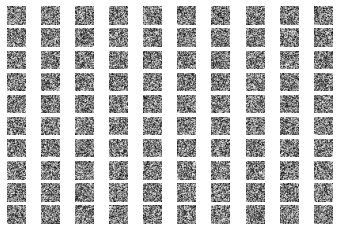

>131, 1/10, d=0.694, g=0.783
>131, 2/10, d=0.685, g=0.742
>131, 3/10, d=0.763, g=0.618
>131, 4/10, d=0.662, g=0.646
>131, 5/10, d=0.724, g=0.650
>131, 6/10, d=0.687, g=0.667
>131, 7/10, d=0.707, g=0.670
>131, 8/10, d=0.728, g=0.627
>131, 9/10, d=0.697, g=0.601
>131, 10/10, d=0.678, g=0.616
>132, 1/10, d=0.715, g=0.693
>132, 2/10, d=0.713, g=0.709
>132, 3/10, d=0.678, g=0.696
>132, 4/10, d=0.659, g=0.684
>132, 5/10, d=0.657, g=0.723
>132, 6/10, d=0.669, g=0.636
>132, 7/10, d=0.676, g=0.645
>132, 8/10, d=0.697, g=0.699
>132, 9/10, d=0.700, g=0.714
>132, 10/10, d=0.711, g=0.737
>133, 1/10, d=0.721, g=0.701
>133, 2/10, d=0.725, g=0.663
>133, 3/10, d=0.701, g=0.657
>133, 4/10, d=0.680, g=0.624
>133, 5/10, d=0.717, g=0.699
>133, 6/10, d=0.682, g=0.712
>133, 7/10, d=0.706, g=0.689
>133, 8/10, d=0.709, g=0.733
>133, 9/10, d=0.697, g=0.743
>133, 10/10, d=0.671, g=0.750
>134, 1/10, d=0.715, g=0.725
>134, 2/10, d=0.714, g=0.718
>134, 3/10, d=0.690, g=0.670
>134, 4/10, d=0.697, g=0.676
>134, 5/10,

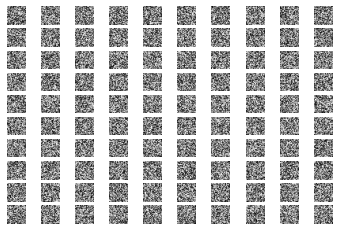

>141, 1/10, d=0.736, g=0.725
>141, 2/10, d=0.671, g=0.724
>141, 3/10, d=0.669, g=0.728
>141, 4/10, d=0.696, g=0.756
>141, 5/10, d=0.717, g=0.767
>141, 6/10, d=0.655, g=0.709
>141, 7/10, d=0.708, g=0.742
>141, 8/10, d=0.716, g=0.685
>141, 9/10, d=0.700, g=0.729
>141, 10/10, d=0.711, g=0.671
>142, 1/10, d=0.726, g=0.631
>142, 2/10, d=0.695, g=0.637
>142, 3/10, d=0.676, g=0.713
>142, 4/10, d=0.727, g=0.625
>142, 5/10, d=0.717, g=0.686
>142, 6/10, d=0.704, g=0.745
>142, 7/10, d=0.701, g=0.804
>142, 8/10, d=0.710, g=0.784
>142, 9/10, d=0.734, g=0.674
>142, 10/10, d=0.687, g=0.620
>143, 1/10, d=0.725, g=0.612
>143, 2/10, d=0.704, g=0.695
>143, 3/10, d=0.751, g=0.711
>143, 4/10, d=0.715, g=0.691
>143, 5/10, d=0.709, g=0.735
>143, 6/10, d=0.693, g=0.737
>143, 7/10, d=0.700, g=0.712
>143, 8/10, d=0.723, g=0.657
>143, 9/10, d=0.732, g=0.635
>143, 10/10, d=0.672, g=0.648
>144, 1/10, d=0.697, g=0.756
>144, 2/10, d=0.681, g=0.754
>144, 3/10, d=0.704, g=0.746
>144, 4/10, d=0.686, g=0.653
>144, 5/10,

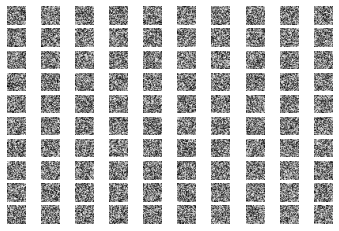

>151, 1/10, d=0.698, g=0.672
>151, 2/10, d=0.705, g=0.643
>151, 3/10, d=0.677, g=0.694
>151, 4/10, d=0.700, g=0.666
>151, 5/10, d=0.701, g=0.653
>151, 6/10, d=0.672, g=0.674
>151, 7/10, d=0.728, g=0.697
>151, 8/10, d=0.697, g=0.663
>151, 9/10, d=0.676, g=0.693
>151, 10/10, d=0.712, g=0.754
>152, 1/10, d=0.737, g=0.741
>152, 2/10, d=0.691, g=0.701
>152, 3/10, d=0.686, g=0.691
>152, 4/10, d=0.687, g=0.698
>152, 5/10, d=0.689, g=0.670
>152, 6/10, d=0.697, g=0.695
>152, 7/10, d=0.688, g=0.670
>152, 8/10, d=0.716, g=0.659
>152, 9/10, d=0.700, g=0.662
>152, 10/10, d=0.717, g=0.692
>153, 1/10, d=0.685, g=0.742
>153, 2/10, d=0.700, g=0.674
>153, 3/10, d=0.674, g=0.718
>153, 4/10, d=0.713, g=0.711
>153, 5/10, d=0.686, g=0.696
>153, 6/10, d=0.723, g=0.675
>153, 7/10, d=0.704, g=0.761
>153, 8/10, d=0.723, g=0.734
>153, 9/10, d=0.665, g=0.764
>153, 10/10, d=0.686, g=0.686
>154, 1/10, d=0.700, g=0.665
>154, 2/10, d=0.718, g=0.692
>154, 3/10, d=0.676, g=0.644
>154, 4/10, d=0.698, g=0.696
>154, 5/10,

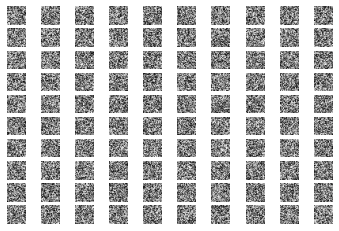

>161, 1/10, d=0.680, g=0.700
>161, 2/10, d=0.713, g=0.679
>161, 3/10, d=0.714, g=0.709
>161, 4/10, d=0.691, g=0.676
>161, 5/10, d=0.741, g=0.669
>161, 6/10, d=0.716, g=0.646
>161, 7/10, d=0.708, g=0.615
>161, 8/10, d=0.705, g=0.663
>161, 9/10, d=0.706, g=0.682
>161, 10/10, d=0.698, g=0.690
>162, 1/10, d=0.692, g=0.760
>162, 2/10, d=0.723, g=0.740
>162, 3/10, d=0.676, g=0.716
>162, 4/10, d=0.669, g=0.709
>162, 5/10, d=0.696, g=0.686
>162, 6/10, d=0.662, g=0.679
>162, 7/10, d=0.692, g=0.670
>162, 8/10, d=0.687, g=0.680
>162, 9/10, d=0.680, g=0.726
>162, 10/10, d=0.718, g=0.721
>163, 1/10, d=0.692, g=0.704
>163, 2/10, d=0.668, g=0.686
>163, 3/10, d=0.716, g=0.724
>163, 4/10, d=0.710, g=0.676
>163, 5/10, d=0.707, g=0.613
>163, 6/10, d=0.684, g=0.615
>163, 7/10, d=0.704, g=0.666
>163, 8/10, d=0.706, g=0.687
>163, 9/10, d=0.698, g=0.715
>163, 10/10, d=0.689, g=0.673
>164, 1/10, d=0.726, g=0.671
>164, 2/10, d=0.723, g=0.668
>164, 3/10, d=0.717, g=0.682
>164, 4/10, d=0.706, g=0.639
>164, 5/10,

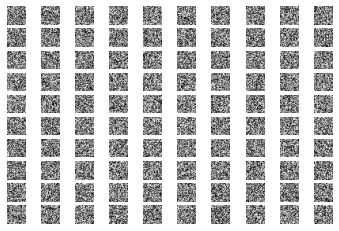

>171, 1/10, d=0.692, g=0.743
>171, 2/10, d=0.707, g=0.784
>171, 3/10, d=0.697, g=0.775
>171, 4/10, d=0.706, g=0.780
>171, 5/10, d=0.737, g=0.712
>171, 6/10, d=0.689, g=0.769
>171, 7/10, d=0.655, g=0.775
>171, 8/10, d=0.664, g=0.770
>171, 9/10, d=0.692, g=0.751
>171, 10/10, d=0.732, g=0.688
>172, 1/10, d=0.687, g=0.775
>172, 2/10, d=0.687, g=0.807
>172, 3/10, d=0.693, g=0.831
>172, 4/10, d=0.658, g=0.747
>172, 5/10, d=0.724, g=0.674
>172, 6/10, d=0.704, g=0.707
>172, 7/10, d=0.699, g=0.699
>172, 8/10, d=0.657, g=0.751
>172, 9/10, d=0.702, g=0.739
>172, 10/10, d=0.705, g=0.732
>173, 1/10, d=0.728, g=0.671
>173, 2/10, d=0.710, g=0.649
>173, 3/10, d=0.722, g=0.655
>173, 4/10, d=0.673, g=0.668
>173, 5/10, d=0.701, g=0.664
>173, 6/10, d=0.704, g=0.640
>173, 7/10, d=0.672, g=0.655
>173, 8/10, d=0.732, g=0.653
>173, 9/10, d=0.697, g=0.667
>173, 10/10, d=0.698, g=0.635
>174, 1/10, d=0.688, g=0.645
>174, 2/10, d=0.708, g=0.641
>174, 3/10, d=0.678, g=0.669
>174, 4/10, d=0.658, g=0.660
>174, 5/10,

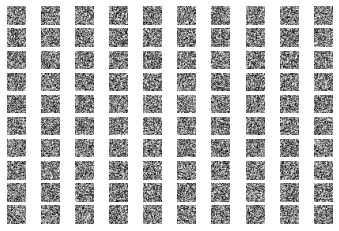

>181, 1/10, d=0.684, g=0.770
>181, 2/10, d=0.690, g=0.717
>181, 3/10, d=0.683, g=0.677
>181, 4/10, d=0.697, g=0.678
>181, 5/10, d=0.690, g=0.678
>181, 6/10, d=0.686, g=0.752
>181, 7/10, d=0.670, g=0.752
>181, 8/10, d=0.672, g=0.732
>181, 9/10, d=0.677, g=0.767
>181, 10/10, d=0.678, g=0.766
>182, 1/10, d=0.729, g=0.675
>182, 2/10, d=0.705, g=0.650
>182, 3/10, d=0.685, g=0.650
>182, 4/10, d=0.687, g=0.739
>182, 5/10, d=0.701, g=0.732
>182, 6/10, d=0.697, g=0.674
>182, 7/10, d=0.749, g=0.665
>182, 8/10, d=0.710, g=0.679
>182, 9/10, d=0.715, g=0.689
>182, 10/10, d=0.686, g=0.714
>183, 1/10, d=0.701, g=0.686
>183, 2/10, d=0.701, g=0.649
>183, 3/10, d=0.708, g=0.666
>183, 4/10, d=0.684, g=0.646
>183, 5/10, d=0.703, g=0.664
>183, 6/10, d=0.706, g=0.672
>183, 7/10, d=0.714, g=0.670
>183, 8/10, d=0.690, g=0.670
>183, 9/10, d=0.699, g=0.710
>183, 10/10, d=0.699, g=0.679
>184, 1/10, d=0.671, g=0.681
>184, 2/10, d=0.664, g=0.696
>184, 3/10, d=0.714, g=0.683
>184, 4/10, d=0.659, g=0.678
>184, 5/10,

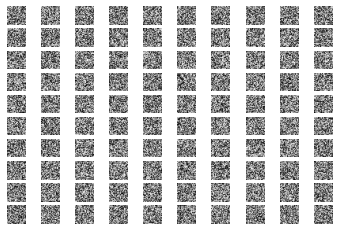

>191, 1/10, d=0.680, g=0.707
>191, 2/10, d=0.688, g=0.670
>191, 3/10, d=0.708, g=0.739
>191, 4/10, d=0.712, g=0.798
>191, 5/10, d=0.706, g=0.735
>191, 6/10, d=0.690, g=0.774
>191, 7/10, d=0.715, g=0.758
>191, 8/10, d=0.725, g=0.762
>191, 9/10, d=0.681, g=0.840
>191, 10/10, d=0.713, g=0.786
>192, 1/10, d=0.674, g=0.761
>192, 2/10, d=0.655, g=0.772
>192, 3/10, d=0.660, g=0.842
>192, 4/10, d=0.640, g=0.817
>192, 5/10, d=0.649, g=0.841
>192, 6/10, d=0.689, g=0.770
>192, 7/10, d=0.687, g=0.739
>192, 8/10, d=0.647, g=0.745
>192, 9/10, d=0.646, g=0.795
>192, 10/10, d=0.671, g=0.793
>193, 1/10, d=0.701, g=0.767
>193, 2/10, d=0.675, g=0.730
>193, 3/10, d=0.727, g=0.682
>193, 4/10, d=0.703, g=0.621
>193, 5/10, d=0.697, g=0.641
>193, 6/10, d=0.709, g=0.679
>193, 7/10, d=0.706, g=0.704
>193, 8/10, d=0.709, g=0.671
>193, 9/10, d=0.703, g=0.628
>193, 10/10, d=0.739, g=0.633
>194, 1/10, d=0.713, g=0.620
>194, 2/10, d=0.677, g=0.625
>194, 3/10, d=0.715, g=0.639
>194, 4/10, d=0.726, g=0.614
>194, 5/10,

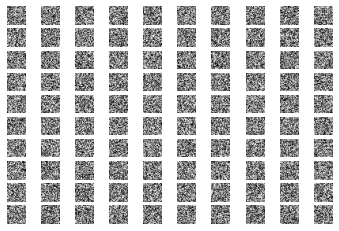

>201, 1/10, d=0.713, g=0.742
>201, 2/10, d=0.683, g=0.696
>201, 3/10, d=0.690, g=0.707
>201, 4/10, d=0.699, g=0.711
>201, 5/10, d=0.689, g=0.657
>201, 6/10, d=0.689, g=0.664
>201, 7/10, d=0.688, g=0.653
>201, 8/10, d=0.677, g=0.668
>201, 9/10, d=0.670, g=0.691
>201, 10/10, d=0.684, g=0.693
>202, 1/10, d=0.685, g=0.706
>202, 2/10, d=0.671, g=0.663
>202, 3/10, d=0.656, g=0.657
>202, 4/10, d=0.652, g=0.691
>202, 5/10, d=0.665, g=0.665
>202, 6/10, d=0.654, g=0.680
>202, 7/10, d=0.670, g=0.704
>202, 8/10, d=0.656, g=0.704
>202, 9/10, d=0.697, g=0.698
>202, 10/10, d=0.684, g=0.705
>203, 1/10, d=0.669, g=0.699
>203, 2/10, d=0.676, g=0.705
>203, 3/10, d=0.671, g=0.672
>203, 4/10, d=0.661, g=0.680
>203, 5/10, d=0.684, g=0.705
>203, 6/10, d=0.706, g=0.709
>203, 7/10, d=0.694, g=0.705
>203, 8/10, d=0.694, g=0.721
>203, 9/10, d=0.684, g=0.727
>203, 10/10, d=0.693, g=0.725
>204, 1/10, d=0.702, g=0.730
>204, 2/10, d=0.683, g=0.716
>204, 3/10, d=0.686, g=0.705
>204, 4/10, d=0.682, g=0.705
>204, 5/10,

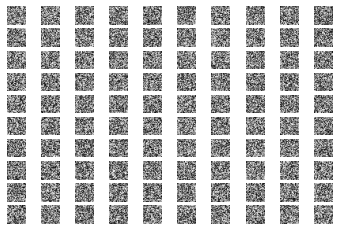

>211, 1/10, d=0.675, g=0.744
>211, 2/10, d=0.678, g=0.717
>211, 3/10, d=0.691, g=0.713
>211, 4/10, d=0.676, g=0.708
>211, 5/10, d=0.662, g=0.716
>211, 6/10, d=0.671, g=0.740
>211, 7/10, d=0.675, g=0.711
>211, 8/10, d=0.678, g=0.677
>211, 9/10, d=0.667, g=0.675
>211, 10/10, d=0.655, g=0.703
>212, 1/10, d=0.667, g=0.748
>212, 2/10, d=0.664, g=0.744
>212, 3/10, d=0.677, g=0.731
>212, 4/10, d=0.655, g=0.732
>212, 5/10, d=0.681, g=0.737
>212, 6/10, d=0.653, g=0.686
>212, 7/10, d=0.678, g=0.709
>212, 8/10, d=0.642, g=0.704
>212, 9/10, d=0.677, g=0.708
>212, 10/10, d=0.672, g=0.711
>213, 1/10, d=0.690, g=0.707
>213, 2/10, d=0.642, g=0.711
>213, 3/10, d=0.667, g=0.705
>213, 4/10, d=0.678, g=0.697
>213, 5/10, d=0.668, g=0.720
>213, 6/10, d=0.690, g=0.700
>213, 7/10, d=0.686, g=0.695
>213, 8/10, d=0.658, g=0.722
>213, 9/10, d=0.671, g=0.728
>213, 10/10, d=0.647, g=0.751
>214, 1/10, d=0.665, g=0.743
>214, 2/10, d=0.677, g=0.719
>214, 3/10, d=0.662, g=0.734
>214, 4/10, d=0.659, g=0.700
>214, 5/10,

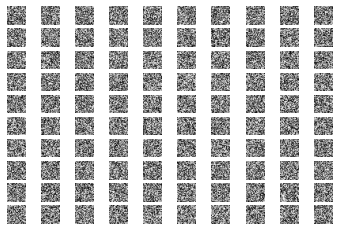

>221, 1/10, d=0.659, g=0.745
>221, 2/10, d=0.646, g=0.753
>221, 3/10, d=0.666, g=0.727
>221, 4/10, d=0.639, g=0.753
>221, 5/10, d=0.673, g=0.729
>221, 6/10, d=0.653, g=0.705
>221, 7/10, d=0.670, g=0.697
>221, 8/10, d=0.670, g=0.760
>221, 9/10, d=0.653, g=0.741
>221, 10/10, d=0.643, g=0.751
>222, 1/10, d=0.686, g=0.729
>222, 2/10, d=0.675, g=0.713
>222, 3/10, d=0.650, g=0.725
>222, 4/10, d=0.631, g=0.717
>222, 5/10, d=0.649, g=0.764
>222, 6/10, d=0.641, g=0.774
>222, 7/10, d=0.617, g=0.799
>222, 8/10, d=0.687, g=0.713
>222, 9/10, d=0.683, g=0.713
>222, 10/10, d=0.662, g=0.712
>223, 1/10, d=0.634, g=0.725
>223, 2/10, d=0.678, g=0.717
>223, 3/10, d=0.652, g=0.743
>223, 4/10, d=0.642, g=0.812
>223, 5/10, d=0.638, g=0.781
>223, 6/10, d=0.682, g=0.758
>223, 7/10, d=0.661, g=0.736
>223, 8/10, d=0.670, g=0.686
>223, 9/10, d=0.631, g=0.737
>223, 10/10, d=0.682, g=0.749
>224, 1/10, d=0.669, g=0.721
>224, 2/10, d=0.662, g=0.728
>224, 3/10, d=0.617, g=0.779
>224, 4/10, d=0.658, g=0.739
>224, 5/10,

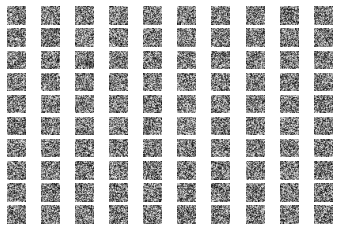

>231, 1/10, d=0.624, g=0.740
>231, 2/10, d=0.666, g=0.750
>231, 3/10, d=0.692, g=0.760
>231, 4/10, d=0.711, g=0.755
>231, 5/10, d=0.674, g=0.741
>231, 6/10, d=0.683, g=0.740
>231, 7/10, d=0.667, g=0.777
>231, 8/10, d=0.702, g=0.780
>231, 9/10, d=0.666, g=0.795
>231, 10/10, d=0.629, g=0.860
>232, 1/10, d=0.649, g=0.859
>232, 2/10, d=0.580, g=0.927
>232, 3/10, d=0.595, g=0.928
>232, 4/10, d=0.548, g=0.955
>232, 5/10, d=0.581, g=0.850
>232, 6/10, d=0.637, g=0.763
>232, 7/10, d=0.631, g=0.783
>232, 8/10, d=0.647, g=0.931
>232, 9/10, d=0.632, g=0.850
>232, 10/10, d=0.726, g=0.757
>233, 1/10, d=0.746, g=0.658
>233, 2/10, d=0.782, g=0.631
>233, 3/10, d=0.771, g=0.620
>233, 4/10, d=0.743, g=0.631
>233, 5/10, d=0.951, g=0.581
>233, 6/10, d=0.911, g=0.504
>233, 7/10, d=0.846, g=0.515
>233, 8/10, d=0.847, g=0.601
>233, 9/10, d=0.759, g=0.595
>233, 10/10, d=0.727, g=0.647
>234, 1/10, d=0.769, g=0.654
>234, 2/10, d=0.708, g=0.652
>234, 3/10, d=0.676, g=0.683
>234, 4/10, d=0.671, g=0.743
>234, 5/10,

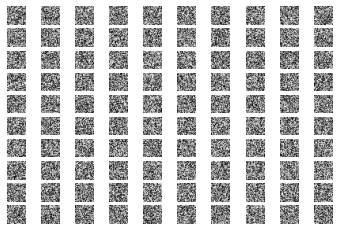

>241, 1/10, d=0.684, g=0.734
>241, 2/10, d=0.663, g=0.704
>241, 3/10, d=0.634, g=0.760
>241, 4/10, d=0.673, g=0.696
>241, 5/10, d=0.690, g=0.690
>241, 6/10, d=0.699, g=0.724
>241, 7/10, d=0.697, g=0.674
>241, 8/10, d=0.672, g=0.697
>241, 9/10, d=0.685, g=0.666
>241, 10/10, d=0.669, g=0.693
>242, 1/10, d=0.661, g=0.725
>242, 2/10, d=0.645, g=0.724
>242, 3/10, d=0.685, g=0.706
>242, 4/10, d=0.649, g=0.743
>242, 5/10, d=0.645, g=0.748
>242, 6/10, d=0.654, g=0.741
>242, 7/10, d=0.645, g=0.751
>242, 8/10, d=0.714, g=0.744
>242, 9/10, d=0.643, g=0.713
>242, 10/10, d=0.668, g=0.726
>243, 1/10, d=0.692, g=0.775
>243, 2/10, d=0.676, g=0.718
>243, 3/10, d=0.675, g=0.712
>243, 4/10, d=0.690, g=0.702
>243, 5/10, d=0.671, g=0.716
>243, 6/10, d=0.700, g=0.732
>243, 7/10, d=0.692, g=0.763
>243, 8/10, d=0.671, g=0.791
>243, 9/10, d=0.670, g=0.811
>243, 10/10, d=0.687, g=0.771
>244, 1/10, d=0.707, g=0.721
>244, 2/10, d=0.686, g=0.701
>244, 3/10, d=0.649, g=0.750
>244, 4/10, d=0.660, g=0.740
>244, 5/10,

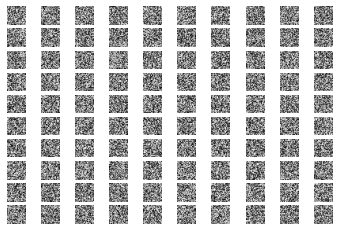

>251, 1/10, d=0.777, g=0.616
>251, 2/10, d=0.728, g=0.688
>251, 3/10, d=0.727, g=0.694
>251, 4/10, d=0.676, g=0.731
>251, 5/10, d=0.680, g=0.725
>251, 6/10, d=0.642, g=0.732
>251, 7/10, d=0.663, g=0.734
>251, 8/10, d=0.652, g=0.699
>251, 9/10, d=0.588, g=0.728
>251, 10/10, d=0.591, g=0.762
>252, 1/10, d=0.610, g=0.776
>252, 2/10, d=0.584, g=0.776
>252, 3/10, d=0.583, g=0.861
>252, 4/10, d=0.579, g=0.851
>252, 5/10, d=0.584, g=0.811
>252, 6/10, d=0.608, g=0.791
>252, 7/10, d=0.643, g=0.755
>252, 8/10, d=0.696, g=0.745
>252, 9/10, d=0.621, g=0.714
>252, 10/10, d=0.665, g=0.788
>253, 1/10, d=0.620, g=0.783
>253, 2/10, d=0.656, g=0.766
>253, 3/10, d=0.657, g=0.776
>253, 4/10, d=0.692, g=0.748
>253, 5/10, d=0.676, g=0.748
>253, 6/10, d=0.648, g=0.769
>253, 7/10, d=0.656, g=0.729
>253, 8/10, d=0.723, g=0.734
>253, 9/10, d=0.695, g=0.767
>253, 10/10, d=0.723, g=0.763
>254, 1/10, d=0.659, g=0.756
>254, 2/10, d=0.699, g=0.785
>254, 3/10, d=0.713, g=0.759
>254, 4/10, d=0.698, g=0.820
>254, 5/10,

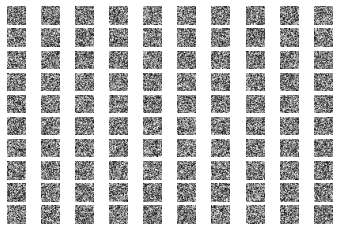

>261, 1/10, d=0.689, g=0.848
>261, 2/10, d=0.637, g=0.895
>261, 3/10, d=0.605, g=0.891
>261, 4/10, d=0.597, g=0.918
>261, 5/10, d=0.491, g=1.061
>261, 6/10, d=0.509, g=1.139
>261, 7/10, d=0.526, g=1.059
>261, 8/10, d=0.639, g=0.932
>261, 9/10, d=0.566, g=0.995
>261, 10/10, d=0.568, g=0.993
>262, 1/10, d=0.559, g=1.055
>262, 2/10, d=0.743, g=0.835
>262, 3/10, d=0.658, g=0.816
>262, 4/10, d=0.683, g=0.844
>262, 5/10, d=0.677, g=0.855
>262, 6/10, d=0.726, g=0.783
>262, 7/10, d=0.648, g=0.861
>262, 8/10, d=0.655, g=0.793
>262, 9/10, d=0.666, g=0.789
>262, 10/10, d=0.679, g=0.761
>263, 1/10, d=0.719, g=0.701
>263, 2/10, d=0.671, g=0.683
>263, 3/10, d=0.637, g=0.706
>263, 4/10, d=0.722, g=0.709
>263, 5/10, d=0.704, g=0.680
>263, 6/10, d=0.772, g=0.654
>263, 7/10, d=0.769, g=0.604
>263, 8/10, d=0.729, g=0.591
>263, 9/10, d=0.780, g=0.650
>263, 10/10, d=0.670, g=0.692
>264, 1/10, d=0.667, g=0.731
>264, 2/10, d=0.635, g=0.698
>264, 3/10, d=0.631, g=0.757
>264, 4/10, d=0.568, g=0.799
>264, 5/10,

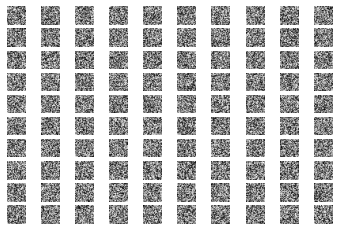

>271, 1/10, d=0.750, g=0.731
>271, 2/10, d=0.722, g=0.772
>271, 3/10, d=0.682, g=0.798
>271, 4/10, d=0.642, g=0.795
>271, 5/10, d=0.616, g=0.772
>271, 6/10, d=0.653, g=0.735
>271, 7/10, d=0.597, g=0.772
>271, 8/10, d=0.632, g=0.787
>271, 9/10, d=0.624, g=0.794
>271, 10/10, d=0.606, g=0.802
>272, 1/10, d=0.621, g=0.804
>272, 2/10, d=0.574, g=0.897
>272, 3/10, d=0.632, g=0.876
>272, 4/10, d=0.646, g=0.749
>272, 5/10, d=0.607, g=0.767
>272, 6/10, d=0.607, g=0.818
>272, 7/10, d=0.611, g=0.872
>272, 8/10, d=0.605, g=0.838
>272, 9/10, d=0.576, g=0.835
>272, 10/10, d=0.595, g=0.818
>273, 1/10, d=0.656, g=0.786
>273, 2/10, d=0.638, g=0.722
>273, 3/10, d=0.602, g=0.748
>273, 4/10, d=0.664, g=0.725
>273, 5/10, d=0.655, g=0.706
>273, 6/10, d=0.643, g=0.748
>273, 7/10, d=0.605, g=0.733
>273, 8/10, d=0.687, g=0.792
>273, 9/10, d=0.675, g=0.792
>273, 10/10, d=0.618, g=0.754
>274, 1/10, d=0.653, g=0.718
>274, 2/10, d=0.679, g=0.715
>274, 3/10, d=0.667, g=0.714
>274, 4/10, d=0.674, g=0.704
>274, 5/10,

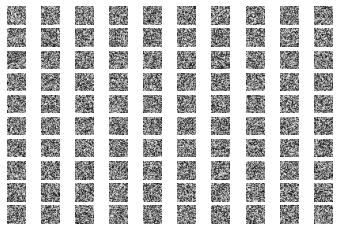

>281, 1/10, d=0.640, g=0.731
>281, 2/10, d=0.667, g=0.775
>281, 3/10, d=0.667, g=0.782
>281, 4/10, d=0.636, g=0.757
>281, 5/10, d=0.675, g=0.734
>281, 6/10, d=0.662, g=0.715
>281, 7/10, d=0.663, g=0.750
>281, 8/10, d=0.719, g=0.753
>281, 9/10, d=0.663, g=0.792
>281, 10/10, d=0.639, g=0.776
>282, 1/10, d=0.660, g=0.770
>282, 2/10, d=0.616, g=0.800
>282, 3/10, d=0.681, g=0.765
>282, 4/10, d=0.729, g=0.737
>282, 5/10, d=0.702, g=0.737
>282, 6/10, d=0.675, g=0.731
>282, 7/10, d=0.704, g=0.729
>282, 8/10, d=0.684, g=0.715
>282, 9/10, d=0.698, g=0.821
>282, 10/10, d=0.703, g=0.764
>283, 1/10, d=0.649, g=0.773
>283, 2/10, d=0.661, g=0.703
>283, 3/10, d=0.639, g=0.786
>283, 4/10, d=0.642, g=0.819
>283, 5/10, d=0.615, g=0.802
>283, 6/10, d=0.628, g=0.807
>283, 7/10, d=0.597, g=0.917
>283, 8/10, d=0.613, g=0.954
>283, 9/10, d=0.610, g=0.860
>283, 10/10, d=0.614, g=0.908
>284, 1/10, d=0.705, g=0.728
>284, 2/10, d=0.697, g=0.646
>284, 3/10, d=0.731, g=0.711
>284, 4/10, d=0.634, g=0.779
>284, 5/10,

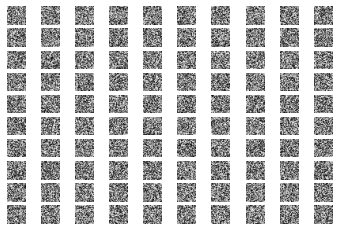

>291, 1/10, d=0.950, g=0.547
>291, 2/10, d=1.016, g=0.558
>291, 3/10, d=0.862, g=0.570
>291, 4/10, d=0.886, g=0.570
>291, 5/10, d=0.824, g=0.596
>291, 6/10, d=0.827, g=0.657
>291, 7/10, d=0.792, g=0.731
>291, 8/10, d=0.765, g=0.697
>291, 9/10, d=0.725, g=0.696
>291, 10/10, d=0.751, g=0.644
>292, 1/10, d=0.634, g=0.644
>292, 2/10, d=0.708, g=0.712
>292, 3/10, d=0.708, g=0.786
>292, 4/10, d=0.675, g=0.825
>292, 5/10, d=0.785, g=0.726
>292, 6/10, d=0.700, g=0.716
>292, 7/10, d=0.723, g=0.703
>292, 8/10, d=0.689, g=0.752
>292, 9/10, d=0.689, g=0.886
>292, 10/10, d=0.685, g=0.780
>293, 1/10, d=0.680, g=0.702
>293, 2/10, d=0.722, g=0.750
>293, 3/10, d=0.660, g=0.726
>293, 4/10, d=0.702, g=0.768
>293, 5/10, d=0.675, g=0.844
>293, 6/10, d=0.714, g=0.797
>293, 7/10, d=0.810, g=0.656
>293, 8/10, d=0.660, g=0.662
>293, 9/10, d=0.643, g=0.792
>293, 10/10, d=0.737, g=0.802
>294, 1/10, d=0.729, g=0.703
>294, 2/10, d=0.698, g=0.699
>294, 3/10, d=0.695, g=0.742
>294, 4/10, d=0.688, g=0.720
>294, 5/10,

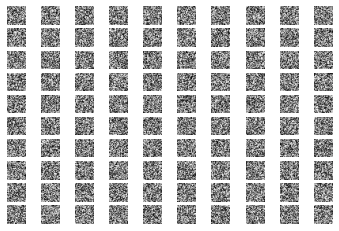

>301, 1/10, d=0.637, g=0.844
>301, 2/10, d=0.646, g=0.823
>301, 3/10, d=0.619, g=0.786
>301, 4/10, d=0.683, g=0.771
>301, 5/10, d=0.654, g=0.758
>301, 6/10, d=0.610, g=0.782
>301, 7/10, d=0.636, g=0.798
>301, 8/10, d=0.639, g=0.828
>301, 9/10, d=0.604, g=0.837
>301, 10/10, d=0.634, g=0.864
>302, 1/10, d=0.632, g=0.816
>302, 2/10, d=0.613, g=0.776
>302, 3/10, d=0.620, g=0.763
>302, 4/10, d=0.639, g=0.786
>302, 5/10, d=0.613, g=0.747
>302, 6/10, d=0.632, g=0.813
>302, 7/10, d=0.600, g=0.802
>302, 8/10, d=0.642, g=0.802
>302, 9/10, d=0.608, g=0.839
>302, 10/10, d=0.602, g=0.768
>303, 1/10, d=0.588, g=0.776
>303, 2/10, d=0.605, g=0.862
>303, 3/10, d=0.649, g=0.893
>303, 4/10, d=0.617, g=0.825
>303, 5/10, d=0.610, g=0.811
>303, 6/10, d=0.607, g=0.820
>303, 7/10, d=0.666, g=0.763
>303, 8/10, d=0.644, g=0.767
>303, 9/10, d=0.664, g=0.770
>303, 10/10, d=0.656, g=0.763
>304, 1/10, d=0.637, g=0.801
>304, 2/10, d=0.626, g=0.731
>304, 3/10, d=0.595, g=0.779
>304, 4/10, d=0.601, g=0.776
>304, 5/10,

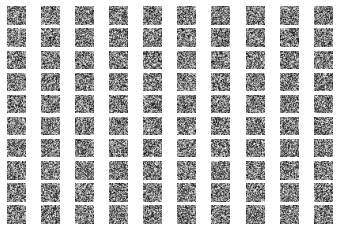

>311, 1/10, d=0.602, g=0.811
>311, 2/10, d=0.649, g=0.764
>311, 3/10, d=0.682, g=0.770
>311, 4/10, d=0.817, g=0.689
>311, 5/10, d=0.829, g=0.702
>311, 6/10, d=0.755, g=0.712
>311, 7/10, d=0.745, g=0.715
>311, 8/10, d=0.769, g=0.590
>311, 9/10, d=0.732, g=0.508
>311, 10/10, d=0.725, g=0.657
>312, 1/10, d=0.748, g=0.655
>312, 2/10, d=0.811, g=0.689
>312, 3/10, d=0.762, g=0.651
>312, 4/10, d=0.740, g=0.674
>312, 5/10, d=0.831, g=0.696
>312, 6/10, d=0.717, g=0.656
>312, 7/10, d=0.762, g=0.641
>312, 8/10, d=0.754, g=0.665
>312, 9/10, d=0.756, g=0.640
>312, 10/10, d=0.728, g=0.651
>313, 1/10, d=0.724, g=0.644
>313, 2/10, d=0.711, g=0.673
>313, 3/10, d=0.731, g=0.636
>313, 4/10, d=0.693, g=0.721
>313, 5/10, d=0.748, g=0.670
>313, 6/10, d=0.676, g=0.683
>313, 7/10, d=0.683, g=0.648
>313, 8/10, d=0.706, g=0.646
>313, 9/10, d=0.695, g=0.669
>313, 10/10, d=0.727, g=0.676
>314, 1/10, d=0.746, g=0.682
>314, 2/10, d=0.735, g=0.672
>314, 3/10, d=0.705, g=0.707
>314, 4/10, d=0.725, g=0.691
>314, 5/10,

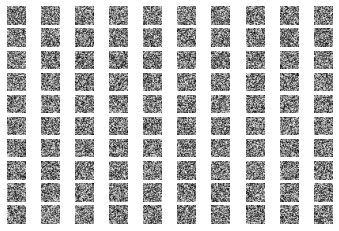

>321, 1/10, d=0.715, g=0.643
>321, 2/10, d=0.735, g=0.600
>321, 3/10, d=0.729, g=0.583
>321, 4/10, d=0.689, g=0.628
>321, 5/10, d=0.711, g=0.747
>321, 6/10, d=0.662, g=0.723
>321, 7/10, d=0.668, g=0.826
>321, 8/10, d=0.715, g=0.693
>321, 9/10, d=0.723, g=0.684
>321, 10/10, d=0.768, g=0.729
>322, 1/10, d=0.769, g=0.717
>322, 2/10, d=0.683, g=0.680
>322, 3/10, d=0.685, g=0.676
>322, 4/10, d=0.739, g=0.640
>322, 5/10, d=0.716, g=0.675
>322, 6/10, d=0.698, g=0.671
>322, 7/10, d=0.724, g=0.690
>322, 8/10, d=0.724, g=0.759
>322, 9/10, d=0.715, g=0.657
>322, 10/10, d=0.686, g=0.682
>323, 1/10, d=0.688, g=0.763
>323, 2/10, d=0.757, g=0.719
>323, 3/10, d=0.675, g=0.720
>323, 4/10, d=0.681, g=0.749
>323, 5/10, d=0.687, g=0.679
>323, 6/10, d=0.753, g=0.651
>323, 7/10, d=0.723, g=0.701
>323, 8/10, d=0.661, g=0.665
>323, 9/10, d=0.740, g=0.662
>323, 10/10, d=0.656, g=0.780
>324, 1/10, d=0.748, g=0.677
>324, 2/10, d=0.702, g=0.767
>324, 3/10, d=0.685, g=0.827
>324, 4/10, d=0.748, g=0.670
>324, 5/10,

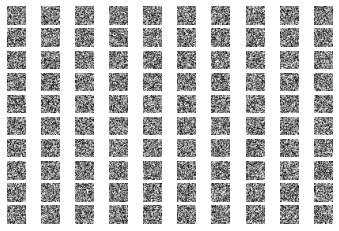

>331, 1/10, d=0.702, g=0.733
>331, 2/10, d=0.674, g=0.730
>331, 3/10, d=0.654, g=0.751
>331, 4/10, d=0.678, g=0.663
>331, 5/10, d=0.679, g=0.716
>331, 6/10, d=0.716, g=0.706
>331, 7/10, d=0.672, g=0.784
>331, 8/10, d=0.697, g=0.758
>331, 9/10, d=0.685, g=0.749
>331, 10/10, d=0.686, g=0.719
>332, 1/10, d=0.704, g=0.756
>332, 2/10, d=0.670, g=0.682
>332, 3/10, d=0.679, g=0.690
>332, 4/10, d=0.685, g=0.746
>332, 5/10, d=0.642, g=0.755
>332, 6/10, d=0.682, g=0.727
>332, 7/10, d=0.739, g=0.720
>332, 8/10, d=0.682, g=0.776
>332, 9/10, d=0.711, g=0.686
>332, 10/10, d=0.694, g=0.753
>333, 1/10, d=0.736, g=0.702
>333, 2/10, d=0.691, g=0.633
>333, 3/10, d=0.726, g=0.654
>333, 4/10, d=0.723, g=0.634
>333, 5/10, d=0.686, g=0.642
>333, 6/10, d=0.708, g=0.645
>333, 7/10, d=0.690, g=0.743
>333, 8/10, d=0.696, g=0.758
>333, 9/10, d=0.675, g=0.664
>333, 10/10, d=0.688, g=0.700
>334, 1/10, d=0.688, g=0.665
>334, 2/10, d=0.682, g=0.745
>334, 3/10, d=0.669, g=0.736
>334, 4/10, d=0.657, g=0.731
>334, 5/10,

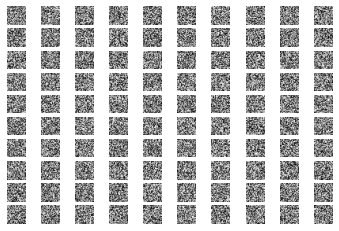

>341, 1/10, d=0.730, g=0.699
>341, 2/10, d=0.676, g=0.702
>341, 3/10, d=0.657, g=0.656
>341, 4/10, d=0.683, g=0.682
>341, 5/10, d=0.701, g=0.727
>341, 6/10, d=0.673, g=0.708
>341, 7/10, d=0.682, g=0.693
>341, 8/10, d=0.691, g=0.719
>341, 9/10, d=0.669, g=0.698
>341, 10/10, d=0.702, g=0.706
>342, 1/10, d=0.707, g=0.732
>342, 2/10, d=0.689, g=0.712
>342, 3/10, d=0.735, g=0.687
>342, 4/10, d=0.668, g=0.704
>342, 5/10, d=0.718, g=0.716
>342, 6/10, d=0.703, g=0.717
>342, 7/10, d=0.733, g=0.782
>342, 8/10, d=0.743, g=0.678
>342, 9/10, d=0.704, g=0.709
>342, 10/10, d=0.672, g=0.722
>343, 1/10, d=0.721, g=0.755
>343, 2/10, d=0.674, g=0.682
>343, 3/10, d=0.702, g=0.707
>343, 4/10, d=0.682, g=0.713
>343, 5/10, d=0.718, g=0.748
>343, 6/10, d=0.677, g=0.778
>343, 7/10, d=0.678, g=0.760
>343, 8/10, d=0.672, g=0.772
>343, 9/10, d=0.677, g=0.715
>343, 10/10, d=0.683, g=0.742
>344, 1/10, d=0.652, g=0.796
>344, 2/10, d=0.651, g=0.862
>344, 3/10, d=0.688, g=0.778
>344, 4/10, d=0.640, g=0.750
>344, 5/10,

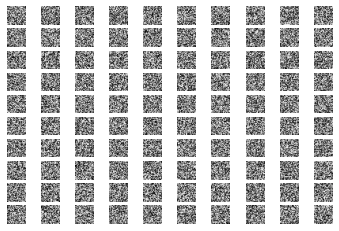

>351, 1/10, d=0.714, g=0.633
>351, 2/10, d=0.707, g=0.640
>351, 3/10, d=0.647, g=0.693
>351, 4/10, d=0.692, g=0.719
>351, 5/10, d=0.706, g=0.743
>351, 6/10, d=0.723, g=0.761
>351, 7/10, d=0.691, g=0.680
>351, 8/10, d=0.694, g=0.661
>351, 9/10, d=0.702, g=0.681
>351, 10/10, d=0.708, g=0.759
>352, 1/10, d=0.680, g=0.709
>352, 2/10, d=0.672, g=0.714
>352, 3/10, d=0.716, g=0.687
>352, 4/10, d=0.691, g=0.693
>352, 5/10, d=0.718, g=0.706
>352, 6/10, d=0.715, g=0.779
>352, 7/10, d=0.707, g=0.738
>352, 8/10, d=0.662, g=0.729
>352, 9/10, d=0.713, g=0.706
>352, 10/10, d=0.714, g=0.759
>353, 1/10, d=0.706, g=0.709
>353, 2/10, d=0.693, g=0.725
>353, 3/10, d=0.678, g=0.686
>353, 4/10, d=0.687, g=0.752
>353, 5/10, d=0.691, g=0.742
>353, 6/10, d=0.686, g=0.796
>353, 7/10, d=0.662, g=0.693
>353, 8/10, d=0.676, g=0.686
>353, 9/10, d=0.632, g=0.727
>353, 10/10, d=0.684, g=0.768
>354, 1/10, d=0.695, g=0.785
>354, 2/10, d=0.718, g=0.682
>354, 3/10, d=0.664, g=0.682
>354, 4/10, d=0.645, g=0.752
>354, 5/10,

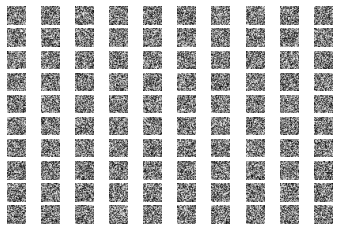

>361, 1/10, d=0.757, g=0.652
>361, 2/10, d=0.711, g=0.685
>361, 3/10, d=0.727, g=0.711
>361, 4/10, d=0.743, g=0.731
>361, 5/10, d=0.735, g=0.646
>361, 6/10, d=0.812, g=0.706
>361, 7/10, d=0.737, g=0.722
>361, 8/10, d=0.687, g=0.711
>361, 9/10, d=0.719, g=0.752
>361, 10/10, d=0.690, g=0.738
>362, 1/10, d=0.669, g=0.764
>362, 2/10, d=0.685, g=0.769
>362, 3/10, d=0.665, g=0.817
>362, 4/10, d=0.671, g=0.793
>362, 5/10, d=0.687, g=0.770
>362, 6/10, d=0.646, g=0.811
>362, 7/10, d=0.693, g=0.769
>362, 8/10, d=0.623, g=0.786
>362, 9/10, d=0.610, g=0.781
>362, 10/10, d=0.656, g=0.765
>363, 1/10, d=0.670, g=0.732
>363, 2/10, d=0.604, g=0.752
>363, 3/10, d=0.672, g=0.702
>363, 4/10, d=0.622, g=0.746
>363, 5/10, d=0.694, g=0.724
>363, 6/10, d=0.705, g=0.675
>363, 7/10, d=0.741, g=0.642
>363, 8/10, d=0.754, g=0.595
>363, 9/10, d=0.710, g=0.635
>363, 10/10, d=0.777, g=0.602
>364, 1/10, d=0.798, g=0.593
>364, 2/10, d=0.745, g=0.596
>364, 3/10, d=0.771, g=0.588
>364, 4/10, d=0.721, g=0.612
>364, 5/10,

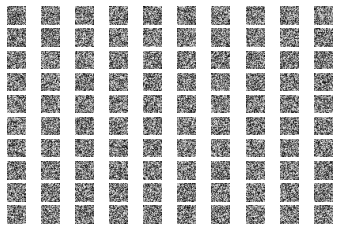

>371, 1/10, d=0.748, g=0.611
>371, 2/10, d=0.697, g=0.642
>371, 3/10, d=0.716, g=0.695
>371, 4/10, d=0.713, g=0.655
>371, 5/10, d=0.709, g=0.678
>371, 6/10, d=0.694, g=0.719
>371, 7/10, d=0.660, g=0.705
>371, 8/10, d=0.680, g=0.701
>371, 9/10, d=0.672, g=0.763
>371, 10/10, d=0.669, g=0.764
>372, 1/10, d=0.600, g=0.762
>372, 2/10, d=0.645, g=0.753
>372, 3/10, d=0.687, g=0.743
>372, 4/10, d=0.709, g=0.775
>372, 5/10, d=0.678, g=0.738
>372, 6/10, d=0.706, g=0.760
>372, 7/10, d=0.687, g=0.767
>372, 8/10, d=0.703, g=0.690
>372, 9/10, d=0.726, g=0.729
>372, 10/10, d=0.711, g=0.746
>373, 1/10, d=0.739, g=0.742
>373, 2/10, d=0.748, g=0.798
>373, 3/10, d=0.691, g=0.765
>373, 4/10, d=0.723, g=0.756
>373, 5/10, d=0.743, g=0.744
>373, 6/10, d=0.735, g=0.744
>373, 7/10, d=0.712, g=0.715
>373, 8/10, d=0.743, g=0.720
>373, 9/10, d=0.758, g=0.711
>373, 10/10, d=0.678, g=0.673
>374, 1/10, d=0.662, g=0.730
>374, 2/10, d=0.681, g=0.764
>374, 3/10, d=0.668, g=0.750
>374, 4/10, d=0.665, g=0.825
>374, 5/10,

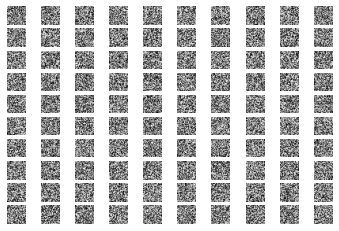

>381, 1/10, d=0.677, g=0.775
>381, 2/10, d=0.676, g=0.728
>381, 3/10, d=0.701, g=0.750
>381, 4/10, d=0.676, g=0.723
>381, 5/10, d=0.685, g=0.711
>381, 6/10, d=0.701, g=0.730
>381, 7/10, d=0.710, g=0.741
>381, 8/10, d=0.673, g=0.720
>381, 9/10, d=0.708, g=0.722
>381, 10/10, d=0.680, g=0.690
>382, 1/10, d=0.672, g=0.682
>382, 2/10, d=0.671, g=0.700
>382, 3/10, d=0.668, g=0.773
>382, 4/10, d=0.702, g=0.765
>382, 5/10, d=0.722, g=0.686
>382, 6/10, d=0.698, g=0.749
>382, 7/10, d=0.669, g=0.685
>382, 8/10, d=0.652, g=0.706
>382, 9/10, d=0.719, g=0.728
>382, 10/10, d=0.714, g=0.660
>383, 1/10, d=0.698, g=0.687
>383, 2/10, d=0.717, g=0.666
>383, 3/10, d=0.673, g=0.740
>383, 4/10, d=0.696, g=0.767
>383, 5/10, d=0.693, g=0.713
>383, 6/10, d=0.707, g=0.648
>383, 7/10, d=0.673, g=0.672
>383, 8/10, d=0.705, g=0.664
>383, 9/10, d=0.696, g=0.652
>383, 10/10, d=0.694, g=0.658
>384, 1/10, d=0.673, g=0.654
>384, 2/10, d=0.700, g=0.695
>384, 3/10, d=0.709, g=0.714
>384, 4/10, d=0.722, g=0.682
>384, 5/10,

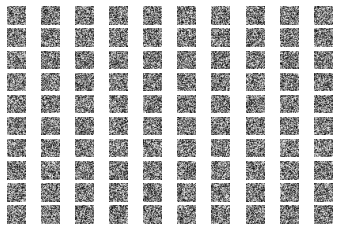

>391, 1/10, d=0.691, g=0.701
>391, 2/10, d=0.686, g=0.726
>391, 3/10, d=0.710, g=0.736
>391, 4/10, d=0.784, g=0.708
>391, 5/10, d=0.706, g=0.717
>391, 6/10, d=0.710, g=0.743
>391, 7/10, d=0.700, g=0.673
>391, 8/10, d=0.735, g=0.689
>391, 9/10, d=0.682, g=0.696
>391, 10/10, d=0.704, g=0.693
>392, 1/10, d=0.705, g=0.736
>392, 2/10, d=0.717, g=0.746
>392, 3/10, d=0.711, g=0.699
>392, 4/10, d=0.726, g=0.695
>392, 5/10, d=0.706, g=0.717
>392, 6/10, d=0.724, g=0.767
>392, 7/10, d=0.714, g=0.715
>392, 8/10, d=0.682, g=0.733
>392, 9/10, d=0.671, g=0.737
>392, 10/10, d=0.688, g=0.735
>393, 1/10, d=0.649, g=0.744
>393, 2/10, d=0.707, g=0.754
>393, 3/10, d=0.664, g=0.721
>393, 4/10, d=0.680, g=0.719
>393, 5/10, d=0.681, g=0.759
>393, 6/10, d=0.692, g=0.846
>393, 7/10, d=0.699, g=0.752
>393, 8/10, d=0.749, g=0.697
>393, 9/10, d=0.727, g=0.685
>393, 10/10, d=0.671, g=0.726
>394, 1/10, d=0.694, g=0.721
>394, 2/10, d=0.672, g=0.734
>394, 3/10, d=0.738, g=0.714
>394, 4/10, d=0.731, g=0.689
>394, 5/10,

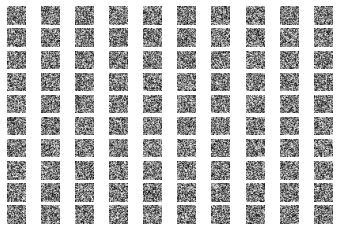

>401, 1/10, d=0.703, g=0.736
>401, 2/10, d=0.727, g=0.658
>401, 3/10, d=0.708, g=0.601
>401, 4/10, d=0.751, g=0.633
>401, 5/10, d=0.711, g=0.665
>401, 6/10, d=0.703, g=0.684
>401, 7/10, d=0.688, g=0.665
>401, 8/10, d=0.702, g=0.670
>401, 9/10, d=0.724, g=0.662
>401, 10/10, d=0.678, g=0.651
>402, 1/10, d=0.722, g=0.676
>402, 2/10, d=0.702, g=0.658
>402, 3/10, d=0.705, g=0.657
>402, 4/10, d=0.677, g=0.668
>402, 5/10, d=0.708, g=0.672
>402, 6/10, d=0.701, g=0.717
>402, 7/10, d=0.678, g=0.659
>402, 8/10, d=0.685, g=0.656
>402, 9/10, d=0.694, g=0.679
>402, 10/10, d=0.693, g=0.679
>403, 1/10, d=0.668, g=0.673
>403, 2/10, d=0.705, g=0.677
>403, 3/10, d=0.674, g=0.651
>403, 4/10, d=0.713, g=0.708
>403, 5/10, d=0.683, g=0.657
>403, 6/10, d=0.712, g=0.666
>403, 7/10, d=0.651, g=0.679
>403, 8/10, d=0.704, g=0.707
>403, 9/10, d=0.662, g=0.693
>403, 10/10, d=0.701, g=0.727
>404, 1/10, d=0.701, g=0.700
>404, 2/10, d=0.716, g=0.711
>404, 3/10, d=0.714, g=0.687
>404, 4/10, d=0.736, g=0.709
>404, 5/10,

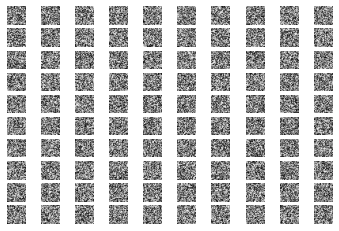

>411, 1/10, d=0.732, g=0.693
>411, 2/10, d=0.695, g=0.727
>411, 3/10, d=0.724, g=0.706
>411, 4/10, d=0.697, g=0.668
>411, 5/10, d=0.725, g=0.695
>411, 6/10, d=0.704, g=0.714
>411, 7/10, d=0.746, g=0.680
>411, 8/10, d=0.682, g=0.722
>411, 9/10, d=0.703, g=0.699
>411, 10/10, d=0.707, g=0.740
>412, 1/10, d=0.688, g=0.713
>412, 2/10, d=0.717, g=0.698
>412, 3/10, d=0.708, g=0.723
>412, 4/10, d=0.697, g=0.725
>412, 5/10, d=0.694, g=0.728
>412, 6/10, d=0.717, g=0.719
>412, 7/10, d=0.666, g=0.717
>412, 8/10, d=0.671, g=0.718
>412, 9/10, d=0.686, g=0.717
>412, 10/10, d=0.692, g=0.730
>413, 1/10, d=0.687, g=0.687
>413, 2/10, d=0.698, g=0.689
>413, 3/10, d=0.666, g=0.699
>413, 4/10, d=0.662, g=0.750
>413, 5/10, d=0.703, g=0.720
>413, 6/10, d=0.690, g=0.698
>413, 7/10, d=0.645, g=0.710
>413, 8/10, d=0.642, g=0.723
>413, 9/10, d=0.682, g=0.650
>413, 10/10, d=0.689, g=0.678
>414, 1/10, d=0.694, g=0.688
>414, 2/10, d=0.693, g=0.678
>414, 3/10, d=0.719, g=0.730
>414, 4/10, d=0.713, g=0.753
>414, 5/10,

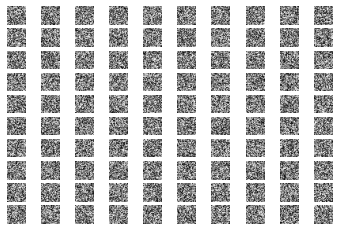

>421, 1/10, d=0.717, g=0.690
>421, 2/10, d=0.714, g=0.735
>421, 3/10, d=0.677, g=0.678
>421, 4/10, d=0.661, g=0.686
>421, 5/10, d=0.749, g=0.684
>421, 6/10, d=0.719, g=0.667
>421, 7/10, d=0.690, g=0.653
>421, 8/10, d=0.740, g=0.658
>421, 9/10, d=0.753, g=0.622
>421, 10/10, d=0.701, g=0.603
>422, 1/10, d=0.752, g=0.630
>422, 2/10, d=0.684, g=0.666
>422, 3/10, d=0.717, g=0.672
>422, 4/10, d=0.697, g=0.689
>422, 5/10, d=0.700, g=0.685
>422, 6/10, d=0.714, g=0.673
>422, 7/10, d=0.665, g=0.672
>422, 8/10, d=0.685, g=0.646
>422, 9/10, d=0.690, g=0.703
>422, 10/10, d=0.671, g=0.701
>423, 1/10, d=0.666, g=0.694
>423, 2/10, d=0.722, g=0.691
>423, 3/10, d=0.687, g=0.689
>423, 4/10, d=0.703, g=0.691
>423, 5/10, d=0.689, g=0.688
>423, 6/10, d=0.681, g=0.725
>423, 7/10, d=0.686, g=0.734
>423, 8/10, d=0.711, g=0.707
>423, 9/10, d=0.704, g=0.716
>423, 10/10, d=0.718, g=0.697
>424, 1/10, d=0.704, g=0.721
>424, 2/10, d=0.707, g=0.738
>424, 3/10, d=0.687, g=0.712
>424, 4/10, d=0.696, g=0.711
>424, 5/10,

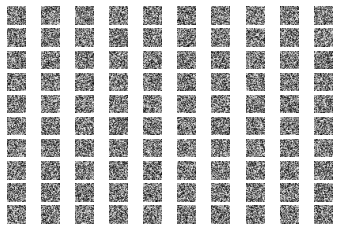

>431, 1/10, d=0.702, g=0.692
>431, 2/10, d=0.683, g=0.694
>431, 3/10, d=0.688, g=0.683
>431, 4/10, d=0.678, g=0.657
>431, 5/10, d=0.670, g=0.684
>431, 6/10, d=0.718, g=0.677
>431, 7/10, d=0.713, g=0.655
>431, 8/10, d=0.685, g=0.680
>431, 9/10, d=0.701, g=0.687
>431, 10/10, d=0.725, g=0.695
>432, 1/10, d=0.688, g=0.660
>432, 2/10, d=0.676, g=0.672
>432, 3/10, d=0.700, g=0.693
>432, 4/10, d=0.696, g=0.711
>432, 5/10, d=0.689, g=0.735
>432, 6/10, d=0.698, g=0.716
>432, 7/10, d=0.694, g=0.695
>432, 8/10, d=0.699, g=0.686
>432, 9/10, d=0.730, g=0.725
>432, 10/10, d=0.731, g=0.691
>433, 1/10, d=0.683, g=0.668
>433, 2/10, d=0.684, g=0.679
>433, 3/10, d=0.708, g=0.679
>433, 4/10, d=0.704, g=0.682
>433, 5/10, d=0.702, g=0.689
>433, 6/10, d=0.724, g=0.695
>433, 7/10, d=0.693, g=0.682
>433, 8/10, d=0.702, g=0.677
>433, 9/10, d=0.718, g=0.720
>433, 10/10, d=0.699, g=0.645
>434, 1/10, d=0.667, g=0.654
>434, 2/10, d=0.690, g=0.668
>434, 3/10, d=0.669, g=0.706
>434, 4/10, d=0.706, g=0.688
>434, 5/10,

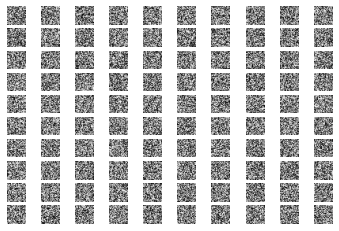

>441, 1/10, d=0.704, g=0.697
>441, 2/10, d=0.717, g=0.733
>441, 3/10, d=0.722, g=0.713
>441, 4/10, d=0.723, g=0.684
>441, 5/10, d=0.682, g=0.681
>441, 6/10, d=0.705, g=0.679
>441, 7/10, d=0.703, g=0.696
>441, 8/10, d=0.681, g=0.665
>441, 9/10, d=0.732, g=0.697
>441, 10/10, d=0.703, g=0.696
>442, 1/10, d=0.720, g=0.701
>442, 2/10, d=0.688, g=0.684
>442, 3/10, d=0.682, g=0.686
>442, 4/10, d=0.695, g=0.676
>442, 5/10, d=0.696, g=0.715
>442, 6/10, d=0.703, g=0.692
>442, 7/10, d=0.685, g=0.710
>442, 8/10, d=0.716, g=0.719
>442, 9/10, d=0.707, g=0.735
>442, 10/10, d=0.681, g=0.704
>443, 1/10, d=0.694, g=0.698
>443, 2/10, d=0.711, g=0.648
>443, 3/10, d=0.688, g=0.695
>443, 4/10, d=0.689, g=0.708
>443, 5/10, d=0.687, g=0.742
>443, 6/10, d=0.674, g=0.718
>443, 7/10, d=0.699, g=0.713
>443, 8/10, d=0.699, g=0.704
>443, 9/10, d=0.702, g=0.714
>443, 10/10, d=0.712, g=0.693
>444, 1/10, d=0.715, g=0.706
>444, 2/10, d=0.697, g=0.676
>444, 3/10, d=0.713, g=0.695
>444, 4/10, d=0.704, g=0.730
>444, 5/10,

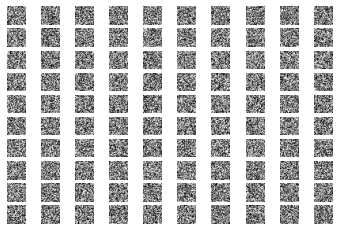

>451, 1/10, d=0.681, g=0.681
>451, 2/10, d=0.690, g=0.737
>451, 3/10, d=0.704, g=0.714
>451, 4/10, d=0.684, g=0.724
>451, 5/10, d=0.700, g=0.726
>451, 6/10, d=0.716, g=0.688
>451, 7/10, d=0.690, g=0.659
>451, 8/10, d=0.699, g=0.706
>451, 9/10, d=0.701, g=0.692
>451, 10/10, d=0.716, g=0.695
>452, 1/10, d=0.705, g=0.699
>452, 2/10, d=0.683, g=0.696
>452, 3/10, d=0.703, g=0.682
>452, 4/10, d=0.701, g=0.689
>452, 5/10, d=0.680, g=0.702
>452, 6/10, d=0.702, g=0.699
>452, 7/10, d=0.719, g=0.704
>452, 8/10, d=0.680, g=0.718
>452, 9/10, d=0.696, g=0.694
>452, 10/10, d=0.692, g=0.684
>453, 1/10, d=0.701, g=0.684
>453, 2/10, d=0.687, g=0.700
>453, 3/10, d=0.691, g=0.700
>453, 4/10, d=0.692, g=0.679
>453, 5/10, d=0.696, g=0.678
>453, 6/10, d=0.700, g=0.705
>453, 7/10, d=0.697, g=0.711
>453, 8/10, d=0.683, g=0.668
>453, 9/10, d=0.700, g=0.700
>453, 10/10, d=0.695, g=0.710
>454, 1/10, d=0.682, g=0.710
>454, 2/10, d=0.679, g=0.705
>454, 3/10, d=0.686, g=0.715
>454, 4/10, d=0.712, g=0.696
>454, 5/10,

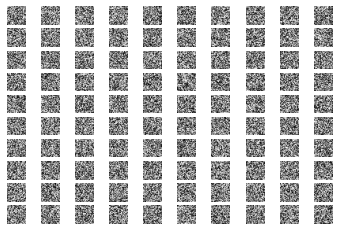

>461, 1/10, d=0.700, g=0.672
>461, 2/10, d=0.683, g=0.699
>461, 3/10, d=0.701, g=0.725
>461, 4/10, d=0.690, g=0.708
>461, 5/10, d=0.700, g=0.729
>461, 6/10, d=0.734, g=0.729
>461, 7/10, d=0.687, g=0.712
>461, 8/10, d=0.729, g=0.705
>461, 9/10, d=0.692, g=0.710
>461, 10/10, d=0.681, g=0.697
>462, 1/10, d=0.688, g=0.675
>462, 2/10, d=0.682, g=0.686
>462, 3/10, d=0.682, g=0.718
>462, 4/10, d=0.663, g=0.698
>462, 5/10, d=0.694, g=0.701
>462, 6/10, d=0.706, g=0.694
>462, 7/10, d=0.702, g=0.669
>462, 8/10, d=0.698, g=0.650
>462, 9/10, d=0.692, g=0.653
>462, 10/10, d=0.692, g=0.670
>463, 1/10, d=0.705, g=0.708
>463, 2/10, d=0.694, g=0.713
>463, 3/10, d=0.706, g=0.697
>463, 4/10, d=0.705, g=0.687
>463, 5/10, d=0.701, g=0.685
>463, 6/10, d=0.696, g=0.700
>463, 7/10, d=0.696, g=0.681
>463, 8/10, d=0.695, g=0.710
>463, 9/10, d=0.701, g=0.725
>463, 10/10, d=0.705, g=0.699
>464, 1/10, d=0.689, g=0.687
>464, 2/10, d=0.680, g=0.706
>464, 3/10, d=0.703, g=0.731
>464, 4/10, d=0.703, g=0.723
>464, 5/10,

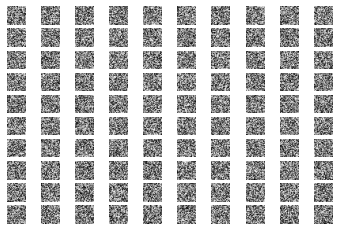

>471, 1/10, d=0.660, g=0.688
>471, 2/10, d=0.697, g=0.654
>471, 3/10, d=0.681, g=0.650
>471, 4/10, d=0.685, g=0.681
>471, 5/10, d=0.713, g=0.675
>471, 6/10, d=0.718, g=0.689
>471, 7/10, d=0.724, g=0.673
>471, 8/10, d=0.705, g=0.669
>471, 9/10, d=0.666, g=0.648
>471, 10/10, d=0.713, g=0.684
>472, 1/10, d=0.685, g=0.664
>472, 2/10, d=0.696, g=0.660
>472, 3/10, d=0.685, g=0.636
>472, 4/10, d=0.681, g=0.680
>472, 5/10, d=0.698, g=0.676
>472, 6/10, d=0.674, g=0.711
>472, 7/10, d=0.681, g=0.689
>472, 8/10, d=0.699, g=0.695
>472, 9/10, d=0.706, g=0.698
>472, 10/10, d=0.692, g=0.688
>473, 1/10, d=0.675, g=0.664
>473, 2/10, d=0.679, g=0.680
>473, 3/10, d=0.705, g=0.716
>473, 4/10, d=0.711, g=0.700
>473, 5/10, d=0.702, g=0.746
>473, 6/10, d=0.698, g=0.732
>473, 7/10, d=0.705, g=0.685
>473, 8/10, d=0.707, g=0.685
>473, 9/10, d=0.701, g=0.708
>473, 10/10, d=0.691, g=0.711
>474, 1/10, d=0.687, g=0.745
>474, 2/10, d=0.724, g=0.756
>474, 3/10, d=0.724, g=0.719
>474, 4/10, d=0.690, g=0.709
>474, 5/10,

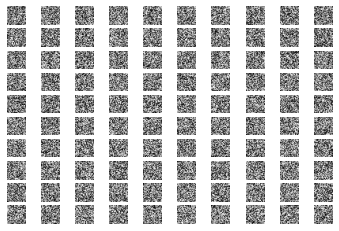

>481, 1/10, d=0.711, g=0.670
>481, 2/10, d=0.689, g=0.671
>481, 3/10, d=0.669, g=0.701
>481, 4/10, d=0.700, g=0.717
>481, 5/10, d=0.698, g=0.704
>481, 6/10, d=0.726, g=0.682
>481, 7/10, d=0.716, g=0.673
>481, 8/10, d=0.672, g=0.686
>481, 9/10, d=0.676, g=0.734
>481, 10/10, d=0.703, g=0.746
>482, 1/10, d=0.687, g=0.719
>482, 2/10, d=0.704, g=0.702
>482, 3/10, d=0.685, g=0.685
>482, 4/10, d=0.681, g=0.673
>482, 5/10, d=0.710, g=0.693
>482, 6/10, d=0.708, g=0.679
>482, 7/10, d=0.690, g=0.695
>482, 8/10, d=0.695, g=0.672
>482, 9/10, d=0.701, g=0.652
>482, 10/10, d=0.689, g=0.688
>483, 1/10, d=0.689, g=0.696
>483, 2/10, d=0.699, g=0.700
>483, 3/10, d=0.696, g=0.678
>483, 4/10, d=0.709, g=0.683
>483, 5/10, d=0.703, g=0.649
>483, 6/10, d=0.698, g=0.662
>483, 7/10, d=0.685, g=0.679
>483, 8/10, d=0.674, g=0.679
>483, 9/10, d=0.690, g=0.667
>483, 10/10, d=0.700, g=0.696
>484, 1/10, d=0.700, g=0.659
>484, 2/10, d=0.701, g=0.674
>484, 3/10, d=0.712, g=0.652
>484, 4/10, d=0.704, g=0.681
>484, 5/10,

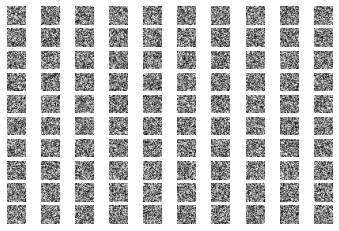

>491, 1/10, d=0.703, g=0.679
>491, 2/10, d=0.697, g=0.697
>491, 3/10, d=0.691, g=0.705
>491, 4/10, d=0.694, g=0.711
>491, 5/10, d=0.698, g=0.704
>491, 6/10, d=0.717, g=0.703
>491, 7/10, d=0.691, g=0.677
>491, 8/10, d=0.685, g=0.653
>491, 9/10, d=0.698, g=0.676
>491, 10/10, d=0.717, g=0.668
>492, 1/10, d=0.704, g=0.669
>492, 2/10, d=0.707, g=0.693
>492, 3/10, d=0.685, g=0.702
>492, 4/10, d=0.676, g=0.689
>492, 5/10, d=0.701, g=0.724
>492, 6/10, d=0.702, g=0.686
>492, 7/10, d=0.687, g=0.706
>492, 8/10, d=0.698, g=0.718
>492, 9/10, d=0.681, g=0.687
>492, 10/10, d=0.692, g=0.677
>493, 1/10, d=0.701, g=0.695
>493, 2/10, d=0.698, g=0.702
>493, 3/10, d=0.695, g=0.698
>493, 4/10, d=0.701, g=0.698
>493, 5/10, d=0.680, g=0.694
>493, 6/10, d=0.678, g=0.707
>493, 7/10, d=0.693, g=0.692
>493, 8/10, d=0.709, g=0.678
>493, 9/10, d=0.695, g=0.704
>493, 10/10, d=0.689, g=0.686
>494, 1/10, d=0.673, g=0.705
>494, 2/10, d=0.703, g=0.738
>494, 3/10, d=0.689, g=0.731
>494, 4/10, d=0.684, g=0.725
>494, 5/10,

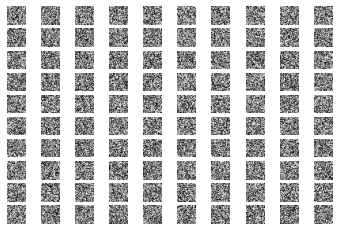

In [ ]:

# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

In [ ]:
# create and save a plot of generated images (reversed grayscale)
def save_plot2(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

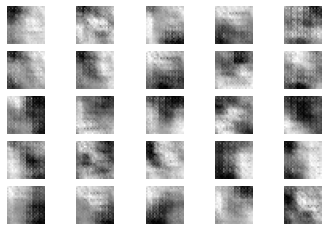

In [ ]:
# load model
model = load_model('generator_model_500.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot2(X, 5)

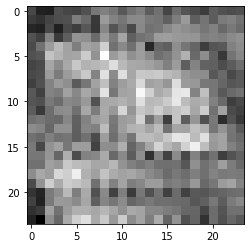

In [ ]:
from numpy import asarray
# load model
model = load_model('generator_model_500.h5')
# all 0s
vector = asarray([[0.0 for _ in range(100)]])
# generate image
X = model.predict(vector)
# plot the result
pyplot.imshow(X[0, :, :, 0], cmap='gray_r')
pyplot.show()